# Load data

In [1]:
import pandas as pd
from constants import NULLABLE_MEASURES
from utils.class_patient import Patients

patients = Patients.loadPatients()
patients.fillMissingMeasureValue(NULLABLE_MEASURES, 0)

# Remove missing data

## Remove features with more than 20% missing

In [2]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


## Remove patients with more than 20% missing features

In [3]:
patients.removePatientByMissingFeatures()
len(patients)

1206

## Display insight

In [4]:
# dfData = patients.getMeasuresBetween(pd.Timedelta(hours=-6), pd.Timedelta(hours=24), "first")

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(patients.getMeasures())

Counter({'age': 1206,
         'chronic_pulmonary_disease': 1206,
         'ckd_stage': 1206,
         'congestive_heart_failure': 1206,
         'dka_type': 1206,
         'gender': 1206,
         'history_aci': 1206,
         'history_ami': 1206,
         'hypertension': 1206,
         'liver_disease': 1206,
         'macroangiopathy': 1206,
         'malignant_cancer': 1206,
         'mechanical_ventilation': 1206,
         'microangiopathy': 1206,
         'oasis': 1206,
         'preiculos': 1206,
         'race': 1206,
         'saps2': 1206,
         'sofa': 1206,
         'use_NaHCO3': 1206,
         'uti': 1206,
         'ag': 1205,
         'bg': 1205,
         'bicarbonate': 1205,
         'bun': 1205,
         'chloride': 1205,
         'egfr': 1205,
         'hr': 1205,
         'potassium': 1205,
         'scr': 1205,
         'sodium': 1205,
         'dbp': 1204,
         'gcs': 1204,
         'gcs_unable': 1204,
         'rr': 1204,
         'sbp': 1204,
         'calci

In [5]:
akdCount = sum([p.akdPositive for p in patients.patientList])

akdCount / len(patients)

0.39303482587064675

# Machine learning

In [6]:
from constants import CATEGORICAL_MEASURES


idColumns = ["subject_id", "hadm_id", "stay_id"]
categoryColumns = CATEGORICAL_MEASURES
labelColumn = "akd"

## Split train-test

In [7]:
splitedPatients = patients.split(5, 27)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

## Define model

In [8]:
import xgboost as xgb

how = "first"

params = {
    "validate_parameters": True,
    "device": "gpu",  # Use GPU acceleration
    "n_jobs": -1,  # Use all CPU cores
    "eval_metric": "logloss",  # Evaluation metric
    "max_depth": 6,  # Maximum depth of a tree
    "min_child_weight": 1,  # Minimum sum of instance weight (hessian) needed in a child
    "gamma": 0,  # Minimum loss reduction required to make a further partition on a leaf node
    "subsample": 0.8,  # Subsample ratio of the training instances
    "colsample_bytree": 0.8,  # Subsample ratio of columns when constructing each tree
    "reg_alpha": 0.01,  # L1 regularization term on weights
    "reg_lambda": 1,  # L2 regularization term on weights
    "objective": "binary:logistic",  # Binary classification objective
    "n_estimators": 1000,  # Number of trees
    "learning_rate": 0.01,  # Learning rate
    "early_stopping_rounds": 10,  # Early stopping
    "verbose": 0,  # Verbosity
}


def createModel():
    model = xgb.XGBClassifier(**params)
    return model

`functionize-notebook` has modified this notebook during execution. The following variables have been injected:

- how: std


## Without validate

### Without fill missing data

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from utils.prepare_data import normalizeData


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list.append(accuracy_score(y_test, y_pred))
    precision_score_list.append(precision_score(y_test, y_pred))
    recall_score_list.append(recall_score(y_test, y_pred))
    auc_score_list.append(roc_auc_score(y_test, y_pred_proba))



/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [00:13:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [00:13:21] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [00:13:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [00:13:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [00:13:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [00:13:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:

print(f"Average AUC: {np.mean(auc_score_list)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list)}")
print(f"Average Precision: {np.mean(precision_score_list)}")
print(f"Average Recall: {np.mean(recall_score_list)}")

Average AUC: 0.7937398582436856
Average Accuracy: 0.7321936833441927
Average Precision: 0.6898806241229355
Average Recall: 0.5823964165733483


### Fill missing with knn

In [12]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_knn = []
precision_score_list_knn = []
recall_score_list_knn = []
auc_score_list_knn = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeAndFillData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_knn.append(precision_score(y_test, y_pred))
    recall_score_list_knn.append(recall_score(y_test, y_pred))
    auc_score_list_knn.append(roc_auc_score(y_test, y_pred_proba))



/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [00:14:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [00:14:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [00:14:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [00:14:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [00:14:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [13]:

print(f"Average AUC: {np.mean(auc_score_list_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_knn)}")

Average AUC: 0.7921200657470799
Average Accuracy: 0.7429752066115702
Average Precision: 0.6949078515101051
Average Recall: 0.6182754759238522


## With validate

### Without fill missing data

In [14]:
from utils.prepare_data import normalizeData


accuracy_score_list_val = []
precision_score_list_val = []
recall_score_list_val = []
auc_score_list_val = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn]) # type: ignore
    y_val = dfVal[labelColumn] # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val.append(accuracy_score(y_test, y_pred))
    precision_score_list_val.append(precision_score(y_test, y_pred))
    recall_score_list_val.append(recall_score(y_test, y_pred))
    auc_score_list_val.append(roc_auc_score(y_test, y_pred_proba))


[0]	validation_0-logloss:0.66613


[1]	validation_0-logloss:0.66343


[2]	validation_0-logloss:0.66086


[3]	validation_0-logloss:0.65831


[4]	validation_0-logloss:0.65563


[5]	validation_0-logloss:0.65279


[6]	validation_0-logloss:0.65031


[7]	validation_0-logloss:0.64805


[8]	validation_0-logloss:0.64616


[9]	validation_0-logloss:0.64366


[10]	validation_0-logloss:0.64140


[11]	validation_0-logloss:0.63869


[12]	validation_0-logloss:0.63708


[13]	validation_0-logloss:0.63478


[14]	validation_0-logloss:0.63286


[15]	validation_0-logloss:0.63042


[16]	validation_0-logloss:0.62836


[17]	validation_0-logloss:0.62626


[18]	validation_0-logloss:0.62444


[19]	validation_0-logloss:0.62195


[20]	validation_0-logloss:0.62057


[21]	validation_0-logloss:0.61866


[22]	validation_0-logloss:0.61673


[23]	validation_0-logloss:0.61549


[24]	validation_0-logloss:0.61388


[25]	validation_0-logloss:0.61206


[26]	validation_0-logloss:0.61061


[27]	validation_0-logloss:0.60892


[28]	validation_0-logloss:0.60767


[29]	validation_0-logloss:0.60616


[30]	validation_0-logloss:0.60447


[31]	validation_0-logloss:0.60235


[32]	validation_0-logloss:0.60071


[33]	validation_0-logloss:0.59913


[34]	validation_0-logloss:0.59781


[35]	validation_0-logloss:0.59632


[36]	validation_0-logloss:0.59466


[37]	validation_0-logloss:0.59309


[38]	validation_0-logloss:0.59111


[39]	validation_0-logloss:0.58961


[40]	validation_0-logloss:0.58840


[41]	validation_0-logloss:0.58733


[42]	validation_0-logloss:0.58586


[43]	validation_0-logloss:0.58402


[44]	validation_0-logloss:0.58244


[45]	validation_0-logloss:0.58078


[46]	validation_0-logloss:0.57984


[47]	validation_0-logloss:0.57877


[48]	validation_0-logloss:0.57786


[49]	validation_0-logloss:0.57642


[50]	validation_0-logloss:0.57528


[51]	validation_0-logloss:0.57382


[52]	validation_0-logloss:0.57297


[53]	validation_0-logloss:0.57168


[54]	validation_0-logloss:0.57034


[55]	validation_0-logloss:0.56913


[56]	validation_0-logloss:0.56884


[57]	validation_0-logloss:0.56751


[58]	validation_0-logloss:0.56623


[59]	validation_0-logloss:0.56480


[60]	validation_0-logloss:0.56358


[61]	validation_0-logloss:0.56229


[62]	validation_0-logloss:0.56122


[63]	validation_0-logloss:0.56020


[64]	validation_0-logloss:0.55916


[65]	validation_0-logloss:0.55823


[66]	validation_0-logloss:0.55695


[67]	validation_0-logloss:0.55629


[68]	validation_0-logloss:0.55542


[69]	validation_0-logloss:0.55445


[70]	validation_0-logloss:0.55326


[71]	validation_0-logloss:0.55182


[72]	validation_0-logloss:0.55109


[73]	validation_0-logloss:0.54998


[74]	validation_0-logloss:0.54914


[75]	validation_0-logloss:0.54825


[76]	validation_0-logloss:0.54751


[77]	validation_0-logloss:0.54629


[78]	validation_0-logloss:0.54550


[79]	validation_0-logloss:0.54464


[80]	validation_0-logloss:0.54360


[81]	validation_0-logloss:0.54301


[82]	validation_0-logloss:0.54223


[83]	validation_0-logloss:0.54174


[84]	validation_0-logloss:0.54070


[85]	validation_0-logloss:0.54028


[86]	validation_0-logloss:0.53937


[87]	validation_0-logloss:0.53857


[88]	validation_0-logloss:0.53769


[89]	validation_0-logloss:0.53674


[90]	validation_0-logloss:0.53583


[91]	validation_0-logloss:0.53512


[92]	validation_0-logloss:0.53426


[93]	validation_0-logloss:0.53374


[94]	validation_0-logloss:0.53324


[95]	validation_0-logloss:0.53307


[96]	validation_0-logloss:0.53260


[97]	validation_0-logloss:0.53196


[98]	validation_0-logloss:0.53093


[99]	validation_0-logloss:0.53005


[100]	validation_0-logloss:0.52949


[101]	validation_0-logloss:0.52870


[102]	validation_0-logloss:0.52794


[103]	validation_0-logloss:0.52731


[104]	validation_0-logloss:0.52704


[105]	validation_0-logloss:0.52636


[106]	validation_0-logloss:0.52552


[107]	validation_0-logloss:0.52467


[108]	validation_0-logloss:0.52405


[109]	validation_0-logloss:0.52346


[110]	validation_0-logloss:0.52271


[111]	validation_0-logloss:0.52220


[112]	validation_0-logloss:0.52176


[113]	validation_0-logloss:0.52150


[114]	validation_0-logloss:0.52064


[115]	validation_0-logloss:0.52051


[116]	validation_0-logloss:0.52009


[117]	validation_0-logloss:0.51996


[118]	validation_0-logloss:0.51959


[119]	validation_0-logloss:0.51885


[120]	validation_0-logloss:0.51822


[121]	validation_0-logloss:0.51793


[122]	validation_0-logloss:0.51771


[123]	validation_0-logloss:0.51697


[124]	validation_0-logloss:0.51624


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [00:14:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[125]	validation_0-logloss:0.51553


[126]	validation_0-logloss:0.51498


[127]	validation_0-logloss:0.51455


[128]	validation_0-logloss:0.51450


[129]	validation_0-logloss:0.51422


[130]	validation_0-logloss:0.51402


[131]	validation_0-logloss:0.51363


[132]	validation_0-logloss:0.51345


[133]	validation_0-logloss:0.51314


[134]	validation_0-logloss:0.51292


[135]	validation_0-logloss:0.51246


[136]	validation_0-logloss:0.51218


[137]	validation_0-logloss:0.51160


[138]	validation_0-logloss:0.51107


[139]	validation_0-logloss:0.51043


[140]	validation_0-logloss:0.51018


[141]	validation_0-logloss:0.50999


[142]	validation_0-logloss:0.50963


[143]	validation_0-logloss:0.50920


[144]	validation_0-logloss:0.50900


[145]	validation_0-logloss:0.50844


[146]	validation_0-logloss:0.50795


[147]	validation_0-logloss:0.50716


[148]	validation_0-logloss:0.50651


[149]	validation_0-logloss:0.50623


[150]	validation_0-logloss:0.50582


[151]	validation_0-logloss:0.50553


[152]	validation_0-logloss:0.50538


[153]	validation_0-logloss:0.50497


[154]	validation_0-logloss:0.50457


[155]	validation_0-logloss:0.50421


[156]	validation_0-logloss:0.50394


[157]	validation_0-logloss:0.50370


[158]	validation_0-logloss:0.50343


[159]	validation_0-logloss:0.50276


[160]	validation_0-logloss:0.50226


[161]	validation_0-logloss:0.50185


[162]	validation_0-logloss:0.50123


[163]	validation_0-logloss:0.50078


[164]	validation_0-logloss:0.50040


[165]	validation_0-logloss:0.49988


[166]	validation_0-logloss:0.49942


[167]	validation_0-logloss:0.49903


[168]	validation_0-logloss:0.49886


[169]	validation_0-logloss:0.49836


[170]	validation_0-logloss:0.49779


[171]	validation_0-logloss:0.49740


[172]	validation_0-logloss:0.49730


[173]	validation_0-logloss:0.49697


[174]	validation_0-logloss:0.49654


[175]	validation_0-logloss:0.49617


[176]	validation_0-logloss:0.49594


[177]	validation_0-logloss:0.49558


[178]	validation_0-logloss:0.49499


[179]	validation_0-logloss:0.49461


[180]	validation_0-logloss:0.49444


[181]	validation_0-logloss:0.49411


[182]	validation_0-logloss:0.49399


[183]	validation_0-logloss:0.49387


[184]	validation_0-logloss:0.49372


[185]	validation_0-logloss:0.49381


[186]	validation_0-logloss:0.49315


[187]	validation_0-logloss:0.49312


[188]	validation_0-logloss:0.49310


[189]	validation_0-logloss:0.49304


[190]	validation_0-logloss:0.49297


[191]	validation_0-logloss:0.49298


[192]	validation_0-logloss:0.49301


[193]	validation_0-logloss:0.49258


[194]	validation_0-logloss:0.49260


[195]	validation_0-logloss:0.49228


[196]	validation_0-logloss:0.49203


[197]	validation_0-logloss:0.49151


[198]	validation_0-logloss:0.49117


[199]	validation_0-logloss:0.49133


[200]	validation_0-logloss:0.49127


[201]	validation_0-logloss:0.49104


[202]	validation_0-logloss:0.49097


[203]	validation_0-logloss:0.49048


[204]	validation_0-logloss:0.49017


[205]	validation_0-logloss:0.49045


[206]	validation_0-logloss:0.49051


[207]	validation_0-logloss:0.49034


[208]	validation_0-logloss:0.48996


[209]	validation_0-logloss:0.49006


[210]	validation_0-logloss:0.48994


[211]	validation_0-logloss:0.49018


[212]	validation_0-logloss:0.48995


[213]	validation_0-logloss:0.48985


[214]	validation_0-logloss:0.48997


[215]	validation_0-logloss:0.49031


[216]	validation_0-logloss:0.49053


[217]	validation_0-logloss:0.49015


[218]	validation_0-logloss:0.49036


[219]	validation_0-logloss:0.49069


[220]	validation_0-logloss:0.49069


[221]	validation_0-logloss:0.49066


[222]	validation_0-logloss:0.49029


[223]	validation_0-logloss:0.48978


[224]	validation_0-logloss:0.48978


[225]	validation_0-logloss:0.48984


[226]	validation_0-logloss:0.48977


[227]	validation_0-logloss:0.48972


[228]	validation_0-logloss:0.48916


[229]	validation_0-logloss:0.48934


[230]	validation_0-logloss:0.48914


[231]	validation_0-logloss:0.48900


[232]	validation_0-logloss:0.48897

[233]	validation_0-logloss:0.48901


[234]	validation_0-logloss:0.48873


[235]	validation_0-logloss:0.48908


[236]	validation_0-logloss:0.48903


[237]	validation_0-logloss:0.48919


[238]	validation_0-logloss:0.48942


[239]	validation_0-logloss:0.48962


[240]	validation_0-logloss:0.48951


[241]	validation_0-logloss:0.48931


[242]	validation_0-logloss:0.48936


[243]	validation_0-logloss:0.48955


[244]	validation_0-logloss:0.48943


[0]	validation_0-logloss:0.66836


[1]	validation_0-logloss:0.66641


[2]	validation_0-logloss:0.66383


[3]	validation_0-logloss:0.66135


[4]	validation_0-logloss:0.65868


[5]	validation_0-logloss:0.65641


[6]	validation_0-logloss:0.65435


[7]	validation_0-logloss:0.65124


[8]	validation_0-logloss:0.64883


[9]	validation_0-logloss:0.64667


[10]	validation_0-logloss:0.64442


[11]	validation_0-logloss:0.64240


[12]	validation_0-logloss:0.64047


[13]	validation_0-logloss:0.63801


[14]	validation_0-logloss:0.63537


[15]	validation_0-logloss:0.63390


[16]	validation_0-logloss:0.63178


[17]	validation_0-logloss:0.62958


[18]	validation_0-logloss:0.62767


[19]	validation_0-logloss:0.62550


[20]	validation_0-logloss:0.62322


[21]	validation_0-logloss:0.62118


[22]	validation_0-logloss:0.61914


[23]	validation_0-logloss:0.61754


[24]	validation_0-logloss:0.61589


[25]	validation_0-logloss:0.61402


[26]	validation_0-logloss:0.61329


[27]	validation_0-logloss:0.61179


[28]	validation_0-logloss:0.61044


[29]	validation_0-logloss:0.60831


[30]	validation_0-logloss:0.60698


[31]	validation_0-logloss:0.60566


[32]	validation_0-logloss:0.60406


[33]	validation_0-logloss:0.60268


[34]	validation_0-logloss:0.60142


[35]	validation_0-logloss:0.59976


[36]	validation_0-logloss:0.59841


[37]	validation_0-logloss:0.59724


[38]	validation_0-logloss:0.59571


[39]	validation_0-logloss:0.59446


[40]	validation_0-logloss:0.59343


[41]	validation_0-logloss:0.59185


[42]	validation_0-logloss:0.59101


[43]	validation_0-logloss:0.59005


[44]	validation_0-logloss:0.58841


[45]	validation_0-logloss:0.58683


[46]	validation_0-logloss:0.58547


[47]	validation_0-logloss:0.58389


[48]	validation_0-logloss:0.58285


[49]	validation_0-logloss:0.58181


[50]	validation_0-logloss:0.58050


[51]	validation_0-logloss:0.57975


[52]	validation_0-logloss:0.57886


[53]	validation_0-logloss:0.57784


[54]	validation_0-logloss:0.57696


[55]	validation_0-logloss:0.57603


[56]	validation_0-logloss:0.57478


[57]	validation_0-logloss:0.57377


[58]	validation_0-logloss:0.57258


[59]	validation_0-logloss:0.57151


[60]	validation_0-logloss:0.57059


[61]	validation_0-logloss:0.56948


[62]	validation_0-logloss:0.56808


[63]	validation_0-logloss:0.56697


[64]	validation_0-logloss:0.56576


[65]	validation_0-logloss:0.56477


[66]	validation_0-logloss:0.56368


[67]	validation_0-logloss:0.56287


[68]	validation_0-logloss:0.56209


[69]	validation_0-logloss:0.56101


[70]	validation_0-logloss:0.56016


[71]	validation_0-logloss:0.55903


[72]	validation_0-logloss:0.55843


[73]	validation_0-logloss:0.55747


[74]	validation_0-logloss:0.55663


[75]	validation_0-logloss:0.55533


[76]	validation_0-logloss:0.55479


[77]	validation_0-logloss:0.55404


[78]	validation_0-logloss:0.55319


[79]	validation_0-logloss:0.55250


[80]	validation_0-logloss:0.55139


[81]	validation_0-logloss:0.55063


[82]	validation_0-logloss:0.54982


[83]	validation_0-logloss:0.54907


[84]	validation_0-logloss:0.54803


[85]	validation_0-logloss:0.54764


[86]	validation_0-logloss:0.54623


[87]	validation_0-logloss:0.54557


[88]	validation_0-logloss:0.54492


[89]	validation_0-logloss:0.54446


[90]	validation_0-logloss:0.54346


[91]	validation_0-logloss:0.54297


[92]	validation_0-logloss:0.54210


[93]	validation_0-logloss:0.54144


[94]	validation_0-logloss:0.54029


[95]	validation_0-logloss:0.53977


[96]	validation_0-logloss:0.53894


[97]	validation_0-logloss:0.53822


[98]	validation_0-logloss:0.53760


[99]	validation_0-logloss:0.53692


[100]	validation_0-logloss:0.53636


[101]	validation_0-logloss:0.53572


[102]	validation_0-logloss:0.53519


[103]	validation_0-logloss:0.53464


[104]	validation_0-logloss:0.53402


[105]	validation_0-logloss:0.53384


[106]	validation_0-logloss:0.53297


[107]	validation_0-logloss:0.53232


[108]	validation_0-logloss:0.53100


[109]	validation_0-logloss:0.53071


[110]	validation_0-logloss:0.53036


[111]	validation_0-logloss:0.52994


[112]	validation_0-logloss:0.52909


[113]	validation_0-logloss:0.52867


[114]	validation_0-logloss:0.52850


[115]	validation_0-logloss:0.52798


[116]	validation_0-logloss:0.52790


[117]	validation_0-logloss:0.52741


[118]	validation_0-logloss:0.52691


[119]	validation_0-logloss:0.52657


[120]	validation_0-logloss:0.52618


[121]	validation_0-logloss:0.52592


[122]	validation_0-logloss:0.52581


[123]	validation_0-logloss:0.52522


[124]	validation_0-logloss:0.52500


[125]	validation_0-logloss:0.52446


[126]	validation_0-logloss:0.52418


[127]	validation_0-logloss:0.52381


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [00:14:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[128]	validation_0-logloss:0.52321


[129]	validation_0-logloss:0.52291


[130]	validation_0-logloss:0.52266


[131]	validation_0-logloss:0.52210


[132]	validation_0-logloss:0.52117


[133]	validation_0-logloss:0.52080


[134]	validation_0-logloss:0.52043


[135]	validation_0-logloss:0.51989


[136]	validation_0-logloss:0.51954


[137]	validation_0-logloss:0.51961


[138]	validation_0-logloss:0.51917


[139]	validation_0-logloss:0.51930


[140]	validation_0-logloss:0.51880


[141]	validation_0-logloss:0.51831


[142]	validation_0-logloss:0.51783


[143]	validation_0-logloss:0.51714


[144]	validation_0-logloss:0.51674


[145]	validation_0-logloss:0.51652


[146]	validation_0-logloss:0.51563


[147]	validation_0-logloss:0.51491


[148]	validation_0-logloss:0.51480


[149]	validation_0-logloss:0.51445


[150]	validation_0-logloss:0.51379


[151]	validation_0-logloss:0.51294


[152]	validation_0-logloss:0.51249


[153]	validation_0-logloss:0.51245


[154]	validation_0-logloss:0.51227


[155]	validation_0-logloss:0.51199


[156]	validation_0-logloss:0.51168


[157]	validation_0-logloss:0.51157


[158]	validation_0-logloss:0.51131


[159]	validation_0-logloss:0.51055


[160]	validation_0-logloss:0.51001


[161]	validation_0-logloss:0.50925


[162]	validation_0-logloss:0.50873


[163]	validation_0-logloss:0.50848


[164]	validation_0-logloss:0.50862


[165]	validation_0-logloss:0.50833


[166]	validation_0-logloss:0.50807


[167]	validation_0-logloss:0.50780


[168]	validation_0-logloss:0.50764


[169]	validation_0-logloss:0.50741


[170]	validation_0-logloss:0.50736


[171]	validation_0-logloss:0.50716


[172]	validation_0-logloss:0.50729


[173]	validation_0-logloss:0.50681


[174]	validation_0-logloss:0.50647


[175]	validation_0-logloss:0.50580


[176]	validation_0-logloss:0.50563


[177]	validation_0-logloss:0.50507


[178]	validation_0-logloss:0.50511


[179]	validation_0-logloss:0.50487


[180]	validation_0-logloss:0.50446


[181]	validation_0-logloss:0.50423


[182]	validation_0-logloss:0.50380


[183]	validation_0-logloss:0.50383


[184]	validation_0-logloss:0.50394


[185]	validation_0-logloss:0.50356

[186]	validation_0-logloss:0.50314


[187]	validation_0-logloss:0.50307


[188]	validation_0-logloss:0.50289


[189]	validation_0-logloss:0.50235


[190]	validation_0-logloss:0.50202


[191]	validation_0-logloss:0.50174


[192]	validation_0-logloss:0.50152


[193]	validation_0-logloss:0.50120


[194]	validation_0-logloss:0.50104


[195]	validation_0-logloss:0.50065


[196]	validation_0-logloss:0.50048


[197]	validation_0-logloss:0.50020


[198]	validation_0-logloss:0.49980


[199]	validation_0-logloss:0.49937


[200]	validation_0-logloss:0.49915


[201]	validation_0-logloss:0.49878


[202]	validation_0-logloss:0.49869


[203]	validation_0-logloss:0.49852


[204]	validation_0-logloss:0.49834


[205]	validation_0-logloss:0.49837


[206]	validation_0-logloss:0.49789


[207]	validation_0-logloss:0.49782


[208]	validation_0-logloss:0.49810


[209]	validation_0-logloss:0.49796


[210]	validation_0-logloss:0.49768


[211]	validation_0-logloss:0.49749


[212]	validation_0-logloss:0.49702


[213]	validation_0-logloss:0.49694


[214]	validation_0-logloss:0.49672


[215]	validation_0-logloss:0.49657


[216]	validation_0-logloss:0.49647


[217]	validation_0-logloss:0.49616


[218]	validation_0-logloss:0.49604


[219]	validation_0-logloss:0.49609


[220]	validation_0-logloss:0.49627


[221]	validation_0-logloss:0.49596


[222]	validation_0-logloss:0.49549


[223]	validation_0-logloss:0.49516


[224]	validation_0-logloss:0.49484


[225]	validation_0-logloss:0.49479


[226]	validation_0-logloss:0.49466


[227]	validation_0-logloss:0.49435


[228]	validation_0-logloss:0.49419


[229]	validation_0-logloss:0.49411


[230]	validation_0-logloss:0.49344


[231]	validation_0-logloss:0.49335


[232]	validation_0-logloss:0.49309


[233]	validation_0-logloss:0.49289


[234]	validation_0-logloss:0.49280


[235]	validation_0-logloss:0.49250


[236]	validation_0-logloss:0.49226


[237]	validation_0-logloss:0.49233


[238]	validation_0-logloss:0.49216


[239]	validation_0-logloss:0.49211


[240]	validation_0-logloss:0.49195


[241]	validation_0-logloss:0.49170


[242]	validation_0-logloss:0.49106


[243]	validation_0-logloss:0.49077


[244]	validation_0-logloss:0.49079


[245]	validation_0-logloss:0.49088


[246]	validation_0-logloss:0.49089


[247]	validation_0-logloss:0.49065


[248]	validation_0-logloss:0.49057


[249]	validation_0-logloss:0.49084


[250]	validation_0-logloss:0.49076


[251]	validation_0-logloss:0.49065


[252]	validation_0-logloss:0.49025


[253]	validation_0-logloss:0.49007


[254]	validation_0-logloss:0.48982


[255]	validation_0-logloss:0.48965


[256]	validation_0-logloss:0.48974


[257]	validation_0-logloss:0.48966


[258]	validation_0-logloss:0.48979


[259]	validation_0-logloss:0.48997


[260]	validation_0-logloss:0.49004


[261]	validation_0-logloss:0.48980


[262]	validation_0-logloss:0.48969


[263]	validation_0-logloss:0.48979


[264]	validation_0-logloss:0.48969


[265]	validation_0-logloss:0.48929


[266]	validation_0-logloss:0.48904


[267]	validation_0-logloss:0.48876


[268]	validation_0-logloss:0.48884


[269]	validation_0-logloss:0.48893


[270]	validation_0-logloss:0.48896


[271]	validation_0-logloss:0.48895


[272]	validation_0-logloss:0.48870


[273]	validation_0-logloss:0.48863


[274]	validation_0-logloss:0.48851


[275]	validation_0-logloss:0.48869


[276]	validation_0-logloss:0.48868


[277]	validation_0-logloss:0.48862


[278]	validation_0-logloss:0.48878


[279]	validation_0-logloss:0.48883


[280]	validation_0-logloss:0.48827


[281]	validation_0-logloss:0.48841


[282]	validation_0-logloss:0.48841


[283]	validation_0-logloss:0.48854


[284]	validation_0-logloss:0.48839


[285]	validation_0-logloss:0.48834


[286]	validation_0-logloss:0.48819


[287]	validation_0-logloss:0.48794


[288]	validation_0-logloss:0.48798


[289]	validation_0-logloss:0.48813


[290]	validation_0-logloss:0.48789


[291]	validation_0-logloss:0.48769


[292]	validation_0-logloss:0.48769

[293]	validation_0-logloss:0.48753


[294]	validation_0-logloss:0.48735


[295]	validation_0-logloss:0.48724


[296]	validation_0-logloss:0.48744


[297]	validation_0-logloss:0.48736


[298]	validation_0-logloss:0.48745


[299]	validation_0-logloss:0.48764


[300]	validation_0-logloss:0.48753


[301]	validation_0-logloss:0.48742


[302]	validation_0-logloss:0.48706


[303]	validation_0-logloss:0.48713


[304]	validation_0-logloss:0.48710


[305]	validation_0-logloss:0.48697


[306]	validation_0-logloss:0.48685


[307]	validation_0-logloss:0.48703


[308]	validation_0-logloss:0.48693


[309]	validation_0-logloss:0.48710


[310]	validation_0-logloss:0.48723


[311]	validation_0-logloss:0.48717


[312]	validation_0-logloss:0.48719


[313]	validation_0-logloss:0.48696


[314]	validation_0-logloss:0.48656


[315]	validation_0-logloss:0.48658


[316]	validation_0-logloss:0.48626


[317]	validation_0-logloss:0.48611


[318]	validation_0-logloss:0.48610


[319]	validation_0-logloss:0.48618


[320]	validation_0-logloss:0.48602

[321]	validation_0-logloss:0.48588


[322]	validation_0-logloss:0.48602


[323]	validation_0-logloss:0.48608


[324]	validation_0-logloss:0.48612


[325]	validation_0-logloss:0.48628


[326]	validation_0-logloss:0.48590


[327]	validation_0-logloss:0.48587


[328]	validation_0-logloss:0.48587


[329]	validation_0-logloss:0.48618


[330]	validation_0-logloss:0.48621


[331]	validation_0-logloss:0.48610


[332]	validation_0-logloss:0.48610


[333]	validation_0-logloss:0.48625


[334]	validation_0-logloss:0.48604


[335]	validation_0-logloss:0.48619


[336]	validation_0-logloss:0.48601


[337]	validation_0-logloss:0.48611


[0]	validation_0-logloss:0.66833


[1]	validation_0-logloss:0.66699


[2]	validation_0-logloss:0.66502


[3]	validation_0-logloss:0.66277


[4]	validation_0-logloss:0.66145


[5]	validation_0-logloss:0.65986


[6]	validation_0-logloss:0.65784


[7]	validation_0-logloss:0.65601


[8]	validation_0-logloss:0.65449


[9]	validation_0-logloss:0.65269


[10]	validation_0-logloss:0.65116


[11]	validation_0-logloss:0.64983


[12]	validation_0-logloss:0.64848


[13]	validation_0-logloss:0.64657


[14]	validation_0-logloss:0.64498


[15]	validation_0-logloss:0.64340


[16]	validation_0-logloss:0.64236


[17]	validation_0-logloss:0.64085


[18]	validation_0-logloss:0.63925


[19]	validation_0-logloss:0.63754


[20]	validation_0-logloss:0.63662


[21]	validation_0-logloss:0.63549


[22]	validation_0-logloss:0.63399


[23]	validation_0-logloss:0.63183


[24]	validation_0-logloss:0.63008


[25]	validation_0-logloss:0.62832


[26]	validation_0-logloss:0.62741


[27]	validation_0-logloss:0.62570


[28]	validation_0-logloss:0.62472


[29]	validation_0-logloss:0.62357


[30]	validation_0-logloss:0.62180


[31]	validation_0-logloss:0.62131


[32]	validation_0-logloss:0.62006


[33]	validation_0-logloss:0.61916


[34]	validation_0-logloss:0.61798


[35]	validation_0-logloss:0.61644


[36]	validation_0-logloss:0.61525


[37]	validation_0-logloss:0.61436


[38]	validation_0-logloss:0.61415


[39]	validation_0-logloss:0.61343


[40]	validation_0-logloss:0.61214


[41]	validation_0-logloss:0.61091


[42]	validation_0-logloss:0.61020


[43]	validation_0-logloss:0.60912


[44]	validation_0-logloss:0.60795


[45]	validation_0-logloss:0.60730


[46]	validation_0-logloss:0.60620


[47]	validation_0-logloss:0.60505


[48]	validation_0-logloss:0.60418


[49]	validation_0-logloss:0.60278


[50]	validation_0-logloss:0.60198


[51]	validation_0-logloss:0.60058


[52]	validation_0-logloss:0.59982


[53]	validation_0-logloss:0.59892


[54]	validation_0-logloss:0.59769


[55]	validation_0-logloss:0.59648


[56]	validation_0-logloss:0.59495


[57]	validation_0-logloss:0.59454


[58]	validation_0-logloss:0.59335


[59]	validation_0-logloss:0.59241


[60]	validation_0-logloss:0.59163


[61]	validation_0-logloss:0.59058


[62]	validation_0-logloss:0.58988


[63]	validation_0-logloss:0.58920


[64]	validation_0-logloss:0.58850


[65]	validation_0-logloss:0.58800


[66]	validation_0-logloss:0.58714


[67]	validation_0-logloss:0.58599


[68]	validation_0-logloss:0.58502


[69]	validation_0-logloss:0.58439


[70]	validation_0-logloss:0.58396


[71]	validation_0-logloss:0.58375


[72]	validation_0-logloss:0.58335


[73]	validation_0-logloss:0.58299


[74]	validation_0-logloss:0.58201


[75]	validation_0-logloss:0.58128


[76]	validation_0-logloss:0.58091


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [00:15:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[77]	validation_0-logloss:0.58075


[78]	validation_0-logloss:0.58024


[79]	validation_0-logloss:0.57962


[80]	validation_0-logloss:0.57883


[81]	validation_0-logloss:0.57855


[82]	validation_0-logloss:0.57797


[83]	validation_0-logloss:0.57717


[84]	validation_0-logloss:0.57642


[85]	validation_0-logloss:0.57577


[86]	validation_0-logloss:0.57495


[87]	validation_0-logloss:0.57483


[88]	validation_0-logloss:0.57433


[89]	validation_0-logloss:0.57403


[90]	validation_0-logloss:0.57412


[91]	validation_0-logloss:0.57383


[92]	validation_0-logloss:0.57363


[93]	validation_0-logloss:0.57350


[94]	validation_0-logloss:0.57293


[95]	validation_0-logloss:0.57251


[96]	validation_0-logloss:0.57168


[97]	validation_0-logloss:0.57182


[98]	validation_0-logloss:0.57149


[99]	validation_0-logloss:0.57123


[100]	validation_0-logloss:0.57084


[101]	validation_0-logloss:0.57054


[102]	validation_0-logloss:0.57041


[103]	validation_0-logloss:0.57008


[104]	validation_0-logloss:0.56997


[105]	validation_0-logloss:0.56946


[106]	validation_0-logloss:0.56878


[107]	validation_0-logloss:0.56826


[108]	validation_0-logloss:0.56788


[109]	validation_0-logloss:0.56803


[110]	validation_0-logloss:0.56772


[111]	validation_0-logloss:0.56736


[112]	validation_0-logloss:0.56708


[113]	validation_0-logloss:0.56687


[114]	validation_0-logloss:0.56618


[115]	validation_0-logloss:0.56581


[116]	validation_0-logloss:0.56586


[117]	validation_0-logloss:0.56569


[118]	validation_0-logloss:0.56534


[119]	validation_0-logloss:0.56462


[120]	validation_0-logloss:0.56451


[121]	validation_0-logloss:0.56457


[122]	validation_0-logloss:0.56408


[123]	validation_0-logloss:0.56354


[124]	validation_0-logloss:0.56306


[125]	validation_0-logloss:0.56261


[126]	validation_0-logloss:0.56211


[127]	validation_0-logloss:0.56224


[128]	validation_0-logloss:0.56227

[129]	validation_0-logloss:0.56178


[130]	validation_0-logloss:0.56156


[131]	validation_0-logloss:0.56101


[132]	validation_0-logloss:0.56054


[133]	validation_0-logloss:0.56040


[134]	validation_0-logloss:0.56023


[135]	validation_0-logloss:0.55989


[136]	validation_0-logloss:0.55990


[137]	validation_0-logloss:0.55924


[138]	validation_0-logloss:0.55904


[139]	validation_0-logloss:0.55877


[140]	validation_0-logloss:0.55862


[141]	validation_0-logloss:0.55818


[142]	validation_0-logloss:0.55771


[143]	validation_0-logloss:0.55787


[144]	validation_0-logloss:0.55746


[145]	validation_0-logloss:0.55747


[146]	validation_0-logloss:0.55702


[147]	validation_0-logloss:0.55721


[148]	validation_0-logloss:0.55691


[149]	validation_0-logloss:0.55687


[150]	validation_0-logloss:0.55680


[151]	validation_0-logloss:0.55613


[152]	validation_0-logloss:0.55579


[153]	validation_0-logloss:0.55580


[154]	validation_0-logloss:0.55560


[155]	validation_0-logloss:0.55523


[156]	validation_0-logloss:0.55489


[157]	validation_0-logloss:0.55460


[158]	validation_0-logloss:0.55435


[159]	validation_0-logloss:0.55396


[160]	validation_0-logloss:0.55366


[161]	validation_0-logloss:0.55344


[162]	validation_0-logloss:0.55303

[163]	validation_0-logloss:0.55292


[164]	validation_0-logloss:0.55239


[165]	validation_0-logloss:0.55210


[166]	validation_0-logloss:0.55197


[167]	validation_0-logloss:0.55204


[168]	validation_0-logloss:0.55180


[169]	validation_0-logloss:0.55178


[170]	validation_0-logloss:0.55168


[171]	validation_0-logloss:0.55173


[172]	validation_0-logloss:0.55136


[173]	validation_0-logloss:0.55131


[174]	validation_0-logloss:0.55159


[175]	validation_0-logloss:0.55126


[176]	validation_0-logloss:0.55127


[177]	validation_0-logloss:0.55118


[178]	validation_0-logloss:0.55135


[179]	validation_0-logloss:0.55130


[180]	validation_0-logloss:0.55152


[181]	validation_0-logloss:0.55129


[182]	validation_0-logloss:0.55098


[183]	validation_0-logloss:0.55111


[184]	validation_0-logloss:0.55091


[185]	validation_0-logloss:0.55072


[186]	validation_0-logloss:0.55045


[187]	validation_0-logloss:0.55045


[188]	validation_0-logloss:0.55020


[189]	validation_0-logloss:0.55048


[190]	validation_0-logloss:0.55023


[191]	validation_0-logloss:0.55003


[192]	validation_0-logloss:0.55004


[193]	validation_0-logloss:0.54988


[194]	validation_0-logloss:0.54991


[195]	validation_0-logloss:0.54970


[196]	validation_0-logloss:0.54964


[197]	validation_0-logloss:0.54955


[198]	validation_0-logloss:0.54959


[199]	validation_0-logloss:0.54947


[200]	validation_0-logloss:0.54942


[201]	validation_0-logloss:0.54902


[202]	validation_0-logloss:0.54907


[203]	validation_0-logloss:0.54883


[204]	validation_0-logloss:0.54901


[205]	validation_0-logloss:0.54936


[206]	validation_0-logloss:0.54972


[207]	validation_0-logloss:0.54947


[208]	validation_0-logloss:0.54944


[209]	validation_0-logloss:0.54932


[210]	validation_0-logloss:0.54897


[211]	validation_0-logloss:0.54890


[212]	validation_0-logloss:0.54887


[213]	validation_0-logloss:0.54865


[214]	validation_0-logloss:0.54844


[215]	validation_0-logloss:0.54829


[216]	validation_0-logloss:0.54833


[217]	validation_0-logloss:0.54802


[218]	validation_0-logloss:0.54798


[219]	validation_0-logloss:0.54817


[220]	validation_0-logloss:0.54796


[221]	validation_0-logloss:0.54782


[222]	validation_0-logloss:0.54779


[223]	validation_0-logloss:0.54741


[224]	validation_0-logloss:0.54696


[225]	validation_0-logloss:0.54710


[226]	validation_0-logloss:0.54709


[227]	validation_0-logloss:0.54718


[228]	validation_0-logloss:0.54733


[229]	validation_0-logloss:0.54760


[230]	validation_0-logloss:0.54741


[231]	validation_0-logloss:0.54727


[232]	validation_0-logloss:0.54727


[233]	validation_0-logloss:0.54748


[234]	validation_0-logloss:0.54735

[0]	validation_0-logloss:0.66827


[1]	validation_0-logloss:0.66608


[2]	validation_0-logloss:0.66345


[3]	validation_0-logloss:0.66096


[4]	validation_0-logloss:0.65851


[5]	validation_0-logloss:0.65672


[6]	validation_0-logloss:0.65454


[7]	validation_0-logloss:0.65240


[8]	validation_0-logloss:0.65054


[9]	validation_0-logloss:0.64905


[10]	validation_0-logloss:0.64704


[11]	validation_0-logloss:0.64481


[12]	validation_0-logloss:0.64298


[13]	validation_0-logloss:0.64160


[14]	validation_0-logloss:0.63959


[15]	validation_0-logloss:0.63793


[16]	validation_0-logloss:0.63638


[17]	validation_0-logloss:0.63457


[18]	validation_0-logloss:0.63319


[19]	validation_0-logloss:0.63204


[20]	validation_0-logloss:0.63016


[21]	validation_0-logloss:0.62822


[22]	validation_0-logloss:0.62655


[23]	validation_0-logloss:0.62528


[24]	validation_0-logloss:0.62386


[25]	validation_0-logloss:0.62232


[26]	validation_0-logloss:0.62077


[27]	validation_0-logloss:0.61933


[28]	validation_0-logloss:0.61780


[29]	validation_0-logloss:0.61625


[30]	validation_0-logloss:0.61498


[31]	validation_0-logloss:0.61318


[32]	validation_0-logloss:0.61188


[33]	validation_0-logloss:0.61099


[34]	validation_0-logloss:0.60912


[35]	validation_0-logloss:0.60747


[36]	validation_0-logloss:0.60602


[37]	validation_0-logloss:0.60473


[38]	validation_0-logloss:0.60335


[39]	validation_0-logloss:0.60206


[40]	validation_0-logloss:0.60103


[41]	validation_0-logloss:0.59997


[42]	validation_0-logloss:0.59820


[43]	validation_0-logloss:0.59756


[44]	validation_0-logloss:0.59662


[45]	validation_0-logloss:0.59582


[46]	validation_0-logloss:0.59457


[47]	validation_0-logloss:0.59332


[48]	validation_0-logloss:0.59213


[49]	validation_0-logloss:0.59098


[50]	validation_0-logloss:0.59018


[51]	validation_0-logloss:0.58872


[52]	validation_0-logloss:0.58809


[53]	validation_0-logloss:0.58740


[54]	validation_0-logloss:0.58658


[55]	validation_0-logloss:0.58605


[56]	validation_0-logloss:0.58493


[57]	validation_0-logloss:0.58430


[58]	validation_0-logloss:0.58293


[59]	validation_0-logloss:0.58254


[60]	validation_0-logloss:0.58110


[61]	validation_0-logloss:0.57979


[62]	validation_0-logloss:0.57923


[63]	validation_0-logloss:0.57809


[64]	validation_0-logloss:0.57727


[65]	validation_0-logloss:0.57675


[66]	validation_0-logloss:0.57605


[67]	validation_0-logloss:0.57493


[68]	validation_0-logloss:0.57387


[69]	validation_0-logloss:0.57333


[70]	validation_0-logloss:0.57259


[71]	validation_0-logloss:0.57194


[72]	validation_0-logloss:0.57132


[73]	validation_0-logloss:0.57081


[74]	validation_0-logloss:0.56976


[75]	validation_0-logloss:0.56972


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [00:15:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[76]	validation_0-logloss:0.56929


[77]	validation_0-logloss:0.56883


[78]	validation_0-logloss:0.56790


[79]	validation_0-logloss:0.56718


[80]	validation_0-logloss:0.56670


[81]	validation_0-logloss:0.56581


[82]	validation_0-logloss:0.56511


[83]	validation_0-logloss:0.56459


[84]	validation_0-logloss:0.56383


[85]	validation_0-logloss:0.56305


[86]	validation_0-logloss:0.56246


[87]	validation_0-logloss:0.56188


[88]	validation_0-logloss:0.56083


[89]	validation_0-logloss:0.56029


[90]	validation_0-logloss:0.55973


[91]	validation_0-logloss:0.55865


[92]	validation_0-logloss:0.55835


[93]	validation_0-logloss:0.55790


[94]	validation_0-logloss:0.55734


[95]	validation_0-logloss:0.55672


[96]	validation_0-logloss:0.55615


[97]	validation_0-logloss:0.55571


[98]	validation_0-logloss:0.55535


[99]	validation_0-logloss:0.55465


[100]	validation_0-logloss:0.55409


[101]	validation_0-logloss:0.55352


[102]	validation_0-logloss:0.55282


[103]	validation_0-logloss:0.55201


[104]	validation_0-logloss:0.55182


[105]	validation_0-logloss:0.55165


[106]	validation_0-logloss:0.55156


[107]	validation_0-logloss:0.55060


[108]	validation_0-logloss:0.54961


[109]	validation_0-logloss:0.54901


[110]	validation_0-logloss:0.54855


[111]	validation_0-logloss:0.54855


[112]	validation_0-logloss:0.54796


[113]	validation_0-logloss:0.54760


[114]	validation_0-logloss:0.54701


[115]	validation_0-logloss:0.54633


[116]	validation_0-logloss:0.54615


[117]	validation_0-logloss:0.54598


[118]	validation_0-logloss:0.54622


[119]	validation_0-logloss:0.54551


[120]	validation_0-logloss:0.54485


[121]	validation_0-logloss:0.54419


[122]	validation_0-logloss:0.54362


[123]	validation_0-logloss:0.54309


[124]	validation_0-logloss:0.54247


[125]	validation_0-logloss:0.54217


[126]	validation_0-logloss:0.54203


[127]	validation_0-logloss:0.54159


[128]	validation_0-logloss:0.54135


[129]	validation_0-logloss:0.54106


[130]	validation_0-logloss:0.54061


[131]	validation_0-logloss:0.54031


[132]	validation_0-logloss:0.53985


[133]	validation_0-logloss:0.53952

[134]	validation_0-logloss:0.53940


[135]	validation_0-logloss:0.53892

[136]	validation_0-logloss:0.53868

[137]	validation_0-logloss:0.53833

[138]	validation_0-logloss:0.53806


[139]	validation_0-logloss:0.53761


[140]	validation_0-logloss:0.53709


[141]	validation_0-logloss:0.53655


[142]	validation_0-logloss:0.53607


[143]	validation_0-logloss:0.53566

[144]	validation_0-logloss:0.53567


[145]	validation_0-logloss:0.53547


[146]	validation_0-logloss:0.53489


[147]	validation_0-logloss:0.53465


[148]	validation_0-logloss:0.53398


[149]	validation_0-logloss:0.53364


[150]	validation_0-logloss:0.53346


[151]	validation_0-logloss:0.53291

[152]	validation_0-logloss:0.53275


[153]	validation_0-logloss:0.53255


[154]	validation_0-logloss:0.53249


[155]	validation_0-logloss:0.53195


[156]	validation_0-logloss:0.53148


[157]	validation_0-logloss:0.53128


[158]	validation_0-logloss:0.53088


[159]	validation_0-logloss:0.53047


[160]	validation_0-logloss:0.52981


[161]	validation_0-logloss:0.52967


[162]	validation_0-logloss:0.52938


[163]	validation_0-logloss:0.52892


[164]	validation_0-logloss:0.52853


[165]	validation_0-logloss:0.52811


[166]	validation_0-logloss:0.52785


[167]	validation_0-logloss:0.52750


[168]	validation_0-logloss:0.52746


[169]	validation_0-logloss:0.52719


[170]	validation_0-logloss:0.52698


[171]	validation_0-logloss:0.52665


[172]	validation_0-logloss:0.52682


[173]	validation_0-logloss:0.52641


[174]	validation_0-logloss:0.52654


[175]	validation_0-logloss:0.52615


[176]	validation_0-logloss:0.52592


[177]	validation_0-logloss:0.52579


[178]	validation_0-logloss:0.52535


[179]	validation_0-logloss:0.52522


[180]	validation_0-logloss:0.52498


[181]	validation_0-logloss:0.52493


[182]	validation_0-logloss:0.52495


[183]	validation_0-logloss:0.52502


[184]	validation_0-logloss:0.52477


[185]	validation_0-logloss:0.52458


[186]	validation_0-logloss:0.52431


[187]	validation_0-logloss:0.52405


[188]	validation_0-logloss:0.52391


[189]	validation_0-logloss:0.52389


[190]	validation_0-logloss:0.52390


[191]	validation_0-logloss:0.52356


[192]	validation_0-logloss:0.52328


[193]	validation_0-logloss:0.52319


[194]	validation_0-logloss:0.52308


[195]	validation_0-logloss:0.52272


[196]	validation_0-logloss:0.52245


[197]	validation_0-logloss:0.52214


[198]	validation_0-logloss:0.52169


[199]	validation_0-logloss:0.52160


[200]	validation_0-logloss:0.52157


[201]	validation_0-logloss:0.52150


[202]	validation_0-logloss:0.52114


[203]	validation_0-logloss:0.52108


[204]	validation_0-logloss:0.52110


[205]	validation_0-logloss:0.52091


[206]	validation_0-logloss:0.52086

[207]	validation_0-logloss:0.52095


[208]	validation_0-logloss:0.52087


[209]	validation_0-logloss:0.52063


[210]	validation_0-logloss:0.52064


[211]	validation_0-logloss:0.52046


[212]	validation_0-logloss:0.52042


[213]	validation_0-logloss:0.52043


[214]	validation_0-logloss:0.52047


[215]	validation_0-logloss:0.52035


[216]	validation_0-logloss:0.52052


[217]	validation_0-logloss:0.52037


[218]	validation_0-logloss:0.52023


[219]	validation_0-logloss:0.52019


[220]	validation_0-logloss:0.51999


[221]	validation_0-logloss:0.52003


[222]	validation_0-logloss:0.51999


[223]	validation_0-logloss:0.52013


[224]	validation_0-logloss:0.52009


[225]	validation_0-logloss:0.52008


[226]	validation_0-logloss:0.52013


[227]	validation_0-logloss:0.52008


[228]	validation_0-logloss:0.51949


[229]	validation_0-logloss:0.51919


[230]	validation_0-logloss:0.51919


[231]	validation_0-logloss:0.51935


[232]	validation_0-logloss:0.51889


[233]	validation_0-logloss:0.51882


[234]	validation_0-logloss:0.51845


[235]	validation_0-logloss:0.51845


[236]	validation_0-logloss:0.51844


[237]	validation_0-logloss:0.51803


[238]	validation_0-logloss:0.51805


[239]	validation_0-logloss:0.51810


[240]	validation_0-logloss:0.51799


[241]	validation_0-logloss:0.51810


[242]	validation_0-logloss:0.51821


[243]	validation_0-logloss:0.51823


[244]	validation_0-logloss:0.51820


[245]	validation_0-logloss:0.51796

[246]	validation_0-logloss:0.51795


[247]	validation_0-logloss:0.51781


[248]	validation_0-logloss:0.51750


[249]	validation_0-logloss:0.51712


[250]	validation_0-logloss:0.51744


[251]	validation_0-logloss:0.51728


[252]	validation_0-logloss:0.51728


[253]	validation_0-logloss:0.51700


[254]	validation_0-logloss:0.51685


[255]	validation_0-logloss:0.51717


[256]	validation_0-logloss:0.51720


[257]	validation_0-logloss:0.51712


[258]	validation_0-logloss:0.51730


[259]	validation_0-logloss:0.51693


[260]	validation_0-logloss:0.51688


[261]	validation_0-logloss:0.51707


[262]	validation_0-logloss:0.51715


[263]	validation_0-logloss:0.51704


[0]	validation_0-logloss:0.66849


[1]	validation_0-logloss:0.66598


[2]	validation_0-logloss:0.66365


[3]	validation_0-logloss:0.66186


[4]	validation_0-logloss:0.65967


[5]	validation_0-logloss:0.65779


[6]	validation_0-logloss:0.65617


[7]	validation_0-logloss:0.65451


[8]	validation_0-logloss:0.65225


[9]	validation_0-logloss:0.65020


[10]	validation_0-logloss:0.64822


[11]	validation_0-logloss:0.64691


[12]	validation_0-logloss:0.64570


[13]	validation_0-logloss:0.64387


[14]	validation_0-logloss:0.64247


[15]	validation_0-logloss:0.64038


[16]	validation_0-logloss:0.63866


[17]	validation_0-logloss:0.63695


[18]	validation_0-logloss:0.63624


[19]	validation_0-logloss:0.63507


[20]	validation_0-logloss:0.63368


[21]	validation_0-logloss:0.63221


[22]	validation_0-logloss:0.63117


[23]	validation_0-logloss:0.63003


[24]	validation_0-logloss:0.62853


[25]	validation_0-logloss:0.62719


[26]	validation_0-logloss:0.62603


[27]	validation_0-logloss:0.62452


[28]	validation_0-logloss:0.62220


[29]	validation_0-logloss:0.62116


[30]	validation_0-logloss:0.62016


[31]	validation_0-logloss:0.61898


[32]	validation_0-logloss:0.61798


[33]	validation_0-logloss:0.61661


[34]	validation_0-logloss:0.61516


[35]	validation_0-logloss:0.61363


[36]	validation_0-logloss:0.61168


[37]	validation_0-logloss:0.61094


[38]	validation_0-logloss:0.61003


[39]	validation_0-logloss:0.60923


[40]	validation_0-logloss:0.60854


[41]	validation_0-logloss:0.60762


[42]	validation_0-logloss:0.60640


[43]	validation_0-logloss:0.60586


[44]	validation_0-logloss:0.60459


[45]	validation_0-logloss:0.60372


[46]	validation_0-logloss:0.60311


[47]	validation_0-logloss:0.60221


[48]	validation_0-logloss:0.60139


[49]	validation_0-logloss:0.60039


[50]	validation_0-logloss:0.59980


[51]	validation_0-logloss:0.59840


[52]	validation_0-logloss:0.59808


[53]	validation_0-logloss:0.59726


[54]	validation_0-logloss:0.59636


[55]	validation_0-logloss:0.59591


[56]	validation_0-logloss:0.59519


[57]	validation_0-logloss:0.59405


[58]	validation_0-logloss:0.59362


[59]	validation_0-logloss:0.59339


[60]	validation_0-logloss:0.59243


[61]	validation_0-logloss:0.59166


[62]	validation_0-logloss:0.59110


[63]	validation_0-logloss:0.59041


[64]	validation_0-logloss:0.58966


[65]	validation_0-logloss:0.58886


[66]	validation_0-logloss:0.58824


[67]	validation_0-logloss:0.58746


[68]	validation_0-logloss:0.58690


[69]	validation_0-logloss:0.58619


[70]	validation_0-logloss:0.58580


[71]	validation_0-logloss:0.58529


[72]	validation_0-logloss:0.58449


[73]	validation_0-logloss:0.58456


[74]	validation_0-logloss:0.58373


[75]	validation_0-logloss:0.58279


[76]	validation_0-logloss:0.58234


[77]	validation_0-logloss:0.58197


[78]	validation_0-logloss:0.58145


[79]	validation_0-logloss:0.58111


[80]	validation_0-logloss:0.58041


[81]	validation_0-logloss:0.58004


[82]	validation_0-logloss:0.58013


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [00:15:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[83]	validation_0-logloss:0.57955


[84]	validation_0-logloss:0.57882


[85]	validation_0-logloss:0.57809


[86]	validation_0-logloss:0.57777


[87]	validation_0-logloss:0.57755


[88]	validation_0-logloss:0.57671


[89]	validation_0-logloss:0.57578


[90]	validation_0-logloss:0.57562


[91]	validation_0-logloss:0.57500


[92]	validation_0-logloss:0.57452


[93]	validation_0-logloss:0.57392


[94]	validation_0-logloss:0.57402

[95]	validation_0-logloss:0.57331


[96]	validation_0-logloss:0.57278


[97]	validation_0-logloss:0.57216


[98]	validation_0-logloss:0.57208


[99]	validation_0-logloss:0.57176

[100]	validation_0-logloss:0.57157


[101]	validation_0-logloss:0.57107


[102]	validation_0-logloss:0.57094


[103]	validation_0-logloss:0.57096


[104]	validation_0-logloss:0.57093


[105]	validation_0-logloss:0.57020


[106]	validation_0-logloss:0.57009


[107]	validation_0-logloss:0.57002


[108]	validation_0-logloss:0.56965


[109]	validation_0-logloss:0.56932


[110]	validation_0-logloss:0.56875


[111]	validation_0-logloss:0.56844


[112]	validation_0-logloss:0.56826


[113]	validation_0-logloss:0.56801


[114]	validation_0-logloss:0.56718


[115]	validation_0-logloss:0.56680


[116]	validation_0-logloss:0.56625


[117]	validation_0-logloss:0.56609


[118]	validation_0-logloss:0.56577


[119]	validation_0-logloss:0.56525


[120]	validation_0-logloss:0.56532


[121]	validation_0-logloss:0.56488


[122]	validation_0-logloss:0.56444


[123]	validation_0-logloss:0.56424


[124]	validation_0-logloss:0.56350


[125]	validation_0-logloss:0.56373


[126]	validation_0-logloss:0.56331


[127]	validation_0-logloss:0.56309


[128]	validation_0-logloss:0.56264


[129]	validation_0-logloss:0.56251


[130]	validation_0-logloss:0.56216


[131]	validation_0-logloss:0.56189


[132]	validation_0-logloss:0.56181


[133]	validation_0-logloss:0.56117


[134]	validation_0-logloss:0.56076


[135]	validation_0-logloss:0.56010


[136]	validation_0-logloss:0.56000


[137]	validation_0-logloss:0.55958


[138]	validation_0-logloss:0.55893


[139]	validation_0-logloss:0.55851


[140]	validation_0-logloss:0.55847


[141]	validation_0-logloss:0.55818


[142]	validation_0-logloss:0.55807


[143]	validation_0-logloss:0.55796


[144]	validation_0-logloss:0.55824


[145]	validation_0-logloss:0.55783


[146]	validation_0-logloss:0.55776


[147]	validation_0-logloss:0.55801


[148]	validation_0-logloss:0.55812


[149]	validation_0-logloss:0.55751


[150]	validation_0-logloss:0.55743


[151]	validation_0-logloss:0.55715


[152]	validation_0-logloss:0.55683


[153]	validation_0-logloss:0.55683


[154]	validation_0-logloss:0.55628


[155]	validation_0-logloss:0.55577


[156]	validation_0-logloss:0.55558


[157]	validation_0-logloss:0.55550


[158]	validation_0-logloss:0.55579


[159]	validation_0-logloss:0.55556


[160]	validation_0-logloss:0.55526


[161]	validation_0-logloss:0.55518


[162]	validation_0-logloss:0.55539


[163]	validation_0-logloss:0.55485


[164]	validation_0-logloss:0.55428


[165]	validation_0-logloss:0.55447


[166]	validation_0-logloss:0.55419


[167]	validation_0-logloss:0.55408


[168]	validation_0-logloss:0.55394


[169]	validation_0-logloss:0.55389


[170]	validation_0-logloss:0.55387


[171]	validation_0-logloss:0.55361


[172]	validation_0-logloss:0.55338


[173]	validation_0-logloss:0.55342


[174]	validation_0-logloss:0.55348


[175]	validation_0-logloss:0.55347


[176]	validation_0-logloss:0.55370


[177]	validation_0-logloss:0.55336


[178]	validation_0-logloss:0.55294


[179]	validation_0-logloss:0.55299


[180]	validation_0-logloss:0.55290


[181]	validation_0-logloss:0.55248


[182]	validation_0-logloss:0.55219


[183]	validation_0-logloss:0.55190


[184]	validation_0-logloss:0.55232


[185]	validation_0-logloss:0.55252


[186]	validation_0-logloss:0.55236


[187]	validation_0-logloss:0.55214


[188]	validation_0-logloss:0.55215


[189]	validation_0-logloss:0.55238


[190]	validation_0-logloss:0.55233


[191]	validation_0-logloss:0.55229


[192]	validation_0-logloss:0.55230


[193]	validation_0-logloss:0.55226


In [15]:


print(f"Average AUC: {np.mean(auc_score_list_val)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val)}")
print(f"Average Precision: {np.mean(precision_score_list_val)}")
print(f"Average Recall: {np.mean(recall_score_list_val)}")

Average AUC: 0.7905587426951022
Average Accuracy: 0.7280374472754707
Average Precision: 0.6966509364132425
Average Recall: 0.5549160134378499


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

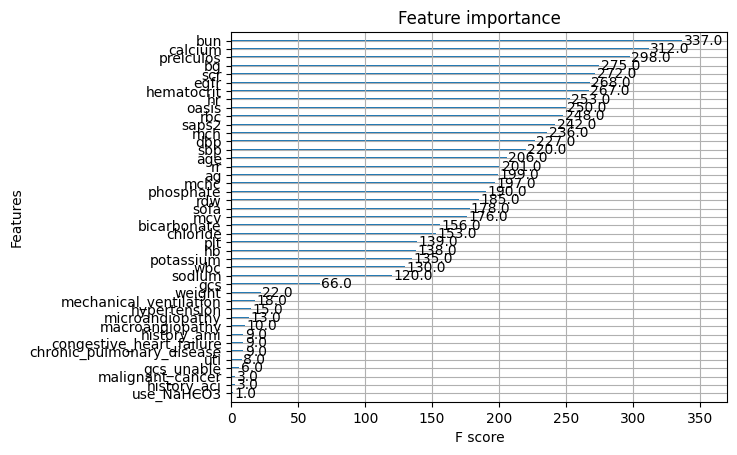

In [16]:
xgb.plot_importance(model)

ImportError: You must install graphviz to plot tree

<Figure size 3000x3000 with 0 Axes>

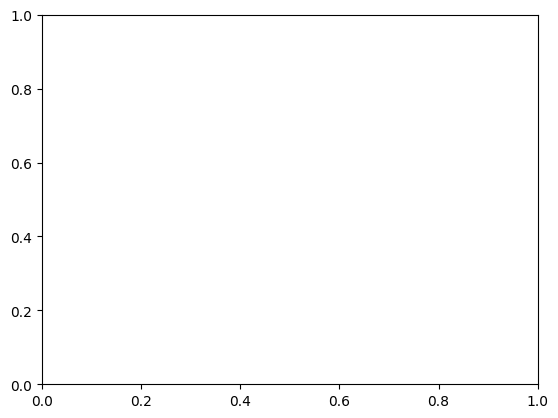

In [17]:
from matplotlib import pyplot as plt


plt.figure(figsize=(30, 30))
xgb.plot_tree(model, num_trees=3)

### Fill missing with knn

In [18]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_val_knn = []
precision_score_list_val_knn = []
recall_score_list_val_knn = []
auc_score_list_val_knn = []
metric_dic_list_val_knn = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeAndFillData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn])  # type: ignore
    y_val = dfVal[labelColumn]  # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_val_knn.append(precision_score(y_test, y_pred))
    recall_score_list_val_knn.append(recall_score(y_test, y_pred))
    auc_score_list_val_knn.append(roc_auc_score(y_test, y_pred_proba))



[0]	validation_0-logloss:0.66659


[1]	validation_0-logloss:0.66373


[2]	validation_0-logloss:0.66140


[3]	validation_0-logloss:0.65863


[4]	validation_0-logloss:0.65593


[5]	validation_0-logloss:0.65302


[6]	validation_0-logloss:0.65100


[7]	validation_0-logloss:0.64840


[8]	validation_0-logloss:0.64597


[9]	validation_0-logloss:0.64392


[10]	validation_0-logloss:0.64191


[11]	validation_0-logloss:0.63978


[12]	validation_0-logloss:0.63791


[13]	validation_0-logloss:0.63523


[14]	validation_0-logloss:0.63349


[15]	validation_0-logloss:0.63094


[16]	validation_0-logloss:0.62883


[17]	validation_0-logloss:0.62678


[18]	validation_0-logloss:0.62504


[19]	validation_0-logloss:0.62365


[20]	validation_0-logloss:0.62154


[21]	validation_0-logloss:0.61948


[22]	validation_0-logloss:0.61804


[23]	validation_0-logloss:0.61650


[24]	validation_0-logloss:0.61479


[25]	validation_0-logloss:0.61236


[26]	validation_0-logloss:0.61114


[27]	validation_0-logloss:0.60921


[28]	validation_0-logloss:0.60773


[29]	validation_0-logloss:0.60683


[30]	validation_0-logloss:0.60477


[31]	validation_0-logloss:0.60356


[32]	validation_0-logloss:0.60180


[33]	validation_0-logloss:0.60051


[34]	validation_0-logloss:0.59915


[35]	validation_0-logloss:0.59738


[36]	validation_0-logloss:0.59666


[37]	validation_0-logloss:0.59475


[38]	validation_0-logloss:0.59300


[39]	validation_0-logloss:0.59218


[40]	validation_0-logloss:0.59080


[41]	validation_0-logloss:0.58981


[42]	validation_0-logloss:0.58838


[43]	validation_0-logloss:0.58659


[44]	validation_0-logloss:0.58490


[45]	validation_0-logloss:0.58360


[46]	validation_0-logloss:0.58296


[47]	validation_0-logloss:0.58177


[48]	validation_0-logloss:0.58084


[49]	validation_0-logloss:0.58001


[50]	validation_0-logloss:0.57879


[51]	validation_0-logloss:0.57729


[52]	validation_0-logloss:0.57603


[53]	validation_0-logloss:0.57443


[54]	validation_0-logloss:0.57282


[55]	validation_0-logloss:0.57187


[56]	validation_0-logloss:0.57113


[57]	validation_0-logloss:0.57008


[58]	validation_0-logloss:0.56927


[59]	validation_0-logloss:0.56845


[60]	validation_0-logloss:0.56733


[61]	validation_0-logloss:0.56617


[62]	validation_0-logloss:0.56496


[63]	validation_0-logloss:0.56392


[64]	validation_0-logloss:0.56262


[65]	validation_0-logloss:0.56138


[66]	validation_0-logloss:0.56018


[67]	validation_0-logloss:0.55954


[68]	validation_0-logloss:0.55872


[69]	validation_0-logloss:0.55782


[70]	validation_0-logloss:0.55725


[71]	validation_0-logloss:0.55653


[72]	validation_0-logloss:0.55561


[73]	validation_0-logloss:0.55478


[74]	validation_0-logloss:0.55388


[75]	validation_0-logloss:0.55287


[76]	validation_0-logloss:0.55201


[77]	validation_0-logloss:0.55089


[78]	validation_0-logloss:0.54966


[79]	validation_0-logloss:0.54896


[80]	validation_0-logloss:0.54807


[81]	validation_0-logloss:0.54730


[82]	validation_0-logloss:0.54614


[83]	validation_0-logloss:0.54520


[84]	validation_0-logloss:0.54491


[85]	validation_0-logloss:0.54450


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [00:15:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[86]	validation_0-logloss:0.54384


[87]	validation_0-logloss:0.54279


[88]	validation_0-logloss:0.54182


[89]	validation_0-logloss:0.54142

[90]	validation_0-logloss:0.54102


[91]	validation_0-logloss:0.54025


[92]	validation_0-logloss:0.53925


[93]	validation_0-logloss:0.53855


[94]	validation_0-logloss:0.53814


[95]	validation_0-logloss:0.53780


[96]	validation_0-logloss:0.53692


[97]	validation_0-logloss:0.53648


[98]	validation_0-logloss:0.53598


[99]	validation_0-logloss:0.53509


[100]	validation_0-logloss:0.53508


[101]	validation_0-logloss:0.53437


[102]	validation_0-logloss:0.53350

[103]	validation_0-logloss:0.53233


[104]	validation_0-logloss:0.53254


[105]	validation_0-logloss:0.53203


[106]	validation_0-logloss:0.53118


[107]	validation_0-logloss:0.53053


[108]	validation_0-logloss:0.52997


[109]	validation_0-logloss:0.52964


[110]	validation_0-logloss:0.52927


[111]	validation_0-logloss:0.52885

[112]	validation_0-logloss:0.52833


[113]	validation_0-logloss:0.52773


[114]	validation_0-logloss:0.52721


[115]	validation_0-logloss:0.52677


[116]	validation_0-logloss:0.52608


[117]	validation_0-logloss:0.52548


[118]	validation_0-logloss:0.52484


[119]	validation_0-logloss:0.52433


[120]	validation_0-logloss:0.52400


[121]	validation_0-logloss:0.52382


[122]	validation_0-logloss:0.52306


[123]	validation_0-logloss:0.52264


[124]	validation_0-logloss:0.52167

[125]	validation_0-logloss:0.52094


[126]	validation_0-logloss:0.52020


[127]	validation_0-logloss:0.52001


[128]	validation_0-logloss:0.52001


[129]	validation_0-logloss:0.51992


[130]	validation_0-logloss:0.51950


[131]	validation_0-logloss:0.51897


[132]	validation_0-logloss:0.51860


[133]	validation_0-logloss:0.51828


[134]	validation_0-logloss:0.51793


[135]	validation_0-logloss:0.51817


[136]	validation_0-logloss:0.51803

[137]	validation_0-logloss:0.51794

[138]	validation_0-logloss:0.51744


[139]	validation_0-logloss:0.51740


[140]	validation_0-logloss:0.51747


[141]	validation_0-logloss:0.51715


[142]	validation_0-logloss:0.51656


[143]	validation_0-logloss:0.51620


[144]	validation_0-logloss:0.51589


[145]	validation_0-logloss:0.51537


[146]	validation_0-logloss:0.51461


[147]	validation_0-logloss:0.51385


[148]	validation_0-logloss:0.51343


[149]	validation_0-logloss:0.51313


[150]	validation_0-logloss:0.51288


[151]	validation_0-logloss:0.51216


[152]	validation_0-logloss:0.51203


[153]	validation_0-logloss:0.51181


[154]	validation_0-logloss:0.51151


[155]	validation_0-logloss:0.51122


[156]	validation_0-logloss:0.51066


[157]	validation_0-logloss:0.51044


[158]	validation_0-logloss:0.51056


[159]	validation_0-logloss:0.51008


[160]	validation_0-logloss:0.50984


[161]	validation_0-logloss:0.50977


[162]	validation_0-logloss:0.50948


[163]	validation_0-logloss:0.50928


[164]	validation_0-logloss:0.50888


[165]	validation_0-logloss:0.50865


[166]	validation_0-logloss:0.50847


[167]	validation_0-logloss:0.50836


[168]	validation_0-logloss:0.50823


[169]	validation_0-logloss:0.50818


[170]	validation_0-logloss:0.50753


[171]	validation_0-logloss:0.50761


[172]	validation_0-logloss:0.50751


[173]	validation_0-logloss:0.50709


[174]	validation_0-logloss:0.50698


[175]	validation_0-logloss:0.50647


[176]	validation_0-logloss:0.50627


[177]	validation_0-logloss:0.50621


[178]	validation_0-logloss:0.50651


[179]	validation_0-logloss:0.50649


[180]	validation_0-logloss:0.50649


[181]	validation_0-logloss:0.50638


[182]	validation_0-logloss:0.50654


[183]	validation_0-logloss:0.50625


[184]	validation_0-logloss:0.50625


[185]	validation_0-logloss:0.50583


[186]	validation_0-logloss:0.50562


[187]	validation_0-logloss:0.50548


[188]	validation_0-logloss:0.50523


[189]	validation_0-logloss:0.50488


[190]	validation_0-logloss:0.50492

[191]	validation_0-logloss:0.50457


[192]	validation_0-logloss:0.50455

[193]	validation_0-logloss:0.50425


[194]	validation_0-logloss:0.50413


[195]	validation_0-logloss:0.50391


[196]	validation_0-logloss:0.50350


[197]	validation_0-logloss:0.50298


[198]	validation_0-logloss:0.50250


[199]	validation_0-logloss:0.50242


[200]	validation_0-logloss:0.50230


[201]	validation_0-logloss:0.50212


[202]	validation_0-logloss:0.50202


[203]	validation_0-logloss:0.50159


[204]	validation_0-logloss:0.50152


[205]	validation_0-logloss:0.50168


[206]	validation_0-logloss:0.50159


[207]	validation_0-logloss:0.50153


[208]	validation_0-logloss:0.50141


[209]	validation_0-logloss:0.50121


[210]	validation_0-logloss:0.50087


[211]	validation_0-logloss:0.50056


[212]	validation_0-logloss:0.50035


[213]	validation_0-logloss:0.50019


[214]	validation_0-logloss:0.50010


[215]	validation_0-logloss:0.50023


[216]	validation_0-logloss:0.50009


[217]	validation_0-logloss:0.50000


[218]	validation_0-logloss:0.50007


[219]	validation_0-logloss:0.49968


[220]	validation_0-logloss:0.49923


[221]	validation_0-logloss:0.49927


[222]	validation_0-logloss:0.49931

[223]	validation_0-logloss:0.49945


[224]	validation_0-logloss:0.49964

[225]	validation_0-logloss:0.49964


[226]	validation_0-logloss:0.49955


[227]	validation_0-logloss:0.49922


[228]	validation_0-logloss:0.49874


[229]	validation_0-logloss:0.49870


[230]	validation_0-logloss:0.49868


[231]	validation_0-logloss:0.49879


[232]	validation_0-logloss:0.49858


[233]	validation_0-logloss:0.49848


[234]	validation_0-logloss:0.49848


[235]	validation_0-logloss:0.49851


[236]	validation_0-logloss:0.49843


[237]	validation_0-logloss:0.49828


[238]	validation_0-logloss:0.49810


[239]	validation_0-logloss:0.49816


[240]	validation_0-logloss:0.49826


[241]	validation_0-logloss:0.49797


[242]	validation_0-logloss:0.49799


[243]	validation_0-logloss:0.49785


[244]	validation_0-logloss:0.49791


[245]	validation_0-logloss:0.49738


[246]	validation_0-logloss:0.49764


[247]	validation_0-logloss:0.49703


[248]	validation_0-logloss:0.49708


[249]	validation_0-logloss:0.49696


[250]	validation_0-logloss:0.49685


[251]	validation_0-logloss:0.49689


[252]	validation_0-logloss:0.49668


[253]	validation_0-logloss:0.49628


[254]	validation_0-logloss:0.49635


[255]	validation_0-logloss:0.49594


[256]	validation_0-logloss:0.49607


[257]	validation_0-logloss:0.49611


[258]	validation_0-logloss:0.49603


[259]	validation_0-logloss:0.49610


[260]	validation_0-logloss:0.49620


[261]	validation_0-logloss:0.49621


[262]	validation_0-logloss:0.49586


[263]	validation_0-logloss:0.49593


[264]	validation_0-logloss:0.49575


[265]	validation_0-logloss:0.49587


[266]	validation_0-logloss:0.49581


[267]	validation_0-logloss:0.49583


[268]	validation_0-logloss:0.49570


[269]	validation_0-logloss:0.49569


[270]	validation_0-logloss:0.49559


[271]	validation_0-logloss:0.49528


[272]	validation_0-logloss:0.49529


[273]	validation_0-logloss:0.49518


[274]	validation_0-logloss:0.49480


[275]	validation_0-logloss:0.49495


[276]	validation_0-logloss:0.49495


[277]	validation_0-logloss:0.49473


[278]	validation_0-logloss:0.49477


[279]	validation_0-logloss:0.49461


[280]	validation_0-logloss:0.49445


[281]	validation_0-logloss:0.49454


[282]	validation_0-logloss:0.49465


[283]	validation_0-logloss:0.49474


[284]	validation_0-logloss:0.49490


[285]	validation_0-logloss:0.49496


[286]	validation_0-logloss:0.49496


[287]	validation_0-logloss:0.49486


[288]	validation_0-logloss:0.49482


[289]	validation_0-logloss:0.49460


[290]	validation_0-logloss:0.49454


[0]	validation_0-logloss:0.66784


[1]	validation_0-logloss:0.66522


[2]	validation_0-logloss:0.66293


[3]	validation_0-logloss:0.66053


[4]	validation_0-logloss:0.65840


[5]	validation_0-logloss:0.65622


[6]	validation_0-logloss:0.65481


[7]	validation_0-logloss:0.65252


[8]	validation_0-logloss:0.65053


[9]	validation_0-logloss:0.64826


[10]	validation_0-logloss:0.64634


[11]	validation_0-logloss:0.64471


[12]	validation_0-logloss:0.64303


[13]	validation_0-logloss:0.64090


[14]	validation_0-logloss:0.63873


[15]	validation_0-logloss:0.63675


[16]	validation_0-logloss:0.63525


[17]	validation_0-logloss:0.63375


[18]	validation_0-logloss:0.63168


[19]	validation_0-logloss:0.62992


[20]	validation_0-logloss:0.62857


[21]	validation_0-logloss:0.62705


[22]	validation_0-logloss:0.62499


[23]	validation_0-logloss:0.62334


[24]	validation_0-logloss:0.62191


[25]	validation_0-logloss:0.61983


[26]	validation_0-logloss:0.61827


[27]	validation_0-logloss:0.61732


[28]	validation_0-logloss:0.61571


[29]	validation_0-logloss:0.61424


[30]	validation_0-logloss:0.61307


[31]	validation_0-logloss:0.61195


[32]	validation_0-logloss:0.61029


[33]	validation_0-logloss:0.60883


[34]	validation_0-logloss:0.60751


[35]	validation_0-logloss:0.60638


[36]	validation_0-logloss:0.60580


[37]	validation_0-logloss:0.60447


[38]	validation_0-logloss:0.60311


[39]	validation_0-logloss:0.60222


[40]	validation_0-logloss:0.60123


[41]	validation_0-logloss:0.59998


[42]	validation_0-logloss:0.59875


[43]	validation_0-logloss:0.59754


[44]	validation_0-logloss:0.59616


[45]	validation_0-logloss:0.59511


[46]	validation_0-logloss:0.59404


[47]	validation_0-logloss:0.59275


[48]	validation_0-logloss:0.59216


[49]	validation_0-logloss:0.59109


[50]	validation_0-logloss:0.59029


[51]	validation_0-logloss:0.58884


[52]	validation_0-logloss:0.58833


[53]	validation_0-logloss:0.58766


[54]	validation_0-logloss:0.58683


[55]	validation_0-logloss:0.58581


[56]	validation_0-logloss:0.58489


[57]	validation_0-logloss:0.58415


[58]	validation_0-logloss:0.58274


[59]	validation_0-logloss:0.58173


[60]	validation_0-logloss:0.58098


[61]	validation_0-logloss:0.58005


[62]	validation_0-logloss:0.57900


[63]	validation_0-logloss:0.57796


[64]	validation_0-logloss:0.57744


[65]	validation_0-logloss:0.57666


[66]	validation_0-logloss:0.57610


[67]	validation_0-logloss:0.57522


[68]	validation_0-logloss:0.57451


[69]	validation_0-logloss:0.57358


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [00:16:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[70]	validation_0-logloss:0.57274


[71]	validation_0-logloss:0.57167


[72]	validation_0-logloss:0.57104


[73]	validation_0-logloss:0.57044


[74]	validation_0-logloss:0.56979


[75]	validation_0-logloss:0.56962


[76]	validation_0-logloss:0.56885


[77]	validation_0-logloss:0.56828


[78]	validation_0-logloss:0.56757


[79]	validation_0-logloss:0.56711


[80]	validation_0-logloss:0.56614


[81]	validation_0-logloss:0.56575


[82]	validation_0-logloss:0.56497


[83]	validation_0-logloss:0.56448

[84]	validation_0-logloss:0.56386


[85]	validation_0-logloss:0.56314


[86]	validation_0-logloss:0.56216


[87]	validation_0-logloss:0.56146


[88]	validation_0-logloss:0.56070


[89]	validation_0-logloss:0.55977


[90]	validation_0-logloss:0.55928


[91]	validation_0-logloss:0.55907


[92]	validation_0-logloss:0.55896


[93]	validation_0-logloss:0.55823


[94]	validation_0-logloss:0.55732


[95]	validation_0-logloss:0.55650


[96]	validation_0-logloss:0.55631


[97]	validation_0-logloss:0.55570


[98]	validation_0-logloss:0.55499


[99]	validation_0-logloss:0.55439


[100]	validation_0-logloss:0.55411


[101]	validation_0-logloss:0.55364


[102]	validation_0-logloss:0.55324


[103]	validation_0-logloss:0.55291


[104]	validation_0-logloss:0.55250


[105]	validation_0-logloss:0.55232

[106]	validation_0-logloss:0.55150


[107]	validation_0-logloss:0.55119


[108]	validation_0-logloss:0.55014


[109]	validation_0-logloss:0.54917


[110]	validation_0-logloss:0.54864


[111]	validation_0-logloss:0.54805


[112]	validation_0-logloss:0.54753


[113]	validation_0-logloss:0.54666


[114]	validation_0-logloss:0.54600


[115]	validation_0-logloss:0.54544


[116]	validation_0-logloss:0.54524


[117]	validation_0-logloss:0.54502


[118]	validation_0-logloss:0.54458


[119]	validation_0-logloss:0.54472

[120]	validation_0-logloss:0.54428


[121]	validation_0-logloss:0.54405


[122]	validation_0-logloss:0.54387


[123]	validation_0-logloss:0.54365


[124]	validation_0-logloss:0.54290


[125]	validation_0-logloss:0.54225


[126]	validation_0-logloss:0.54139


[127]	validation_0-logloss:0.54072


[128]	validation_0-logloss:0.54076


[129]	validation_0-logloss:0.54079


[130]	validation_0-logloss:0.54017


[131]	validation_0-logloss:0.53966


[132]	validation_0-logloss:0.53887


[133]	validation_0-logloss:0.53852


[134]	validation_0-logloss:0.53831


[135]	validation_0-logloss:0.53825


[136]	validation_0-logloss:0.53756


[137]	validation_0-logloss:0.53788


[138]	validation_0-logloss:0.53772


[139]	validation_0-logloss:0.53756


[140]	validation_0-logloss:0.53748


[141]	validation_0-logloss:0.53709


[142]	validation_0-logloss:0.53663


[143]	validation_0-logloss:0.53626


[144]	validation_0-logloss:0.53603


[145]	validation_0-logloss:0.53580


[146]	validation_0-logloss:0.53568


[147]	validation_0-logloss:0.53529


[148]	validation_0-logloss:0.53541


[149]	validation_0-logloss:0.53523


[150]	validation_0-logloss:0.53466


[151]	validation_0-logloss:0.53431


[152]	validation_0-logloss:0.53401


[153]	validation_0-logloss:0.53419


[154]	validation_0-logloss:0.53383


[155]	validation_0-logloss:0.53360


[156]	validation_0-logloss:0.53335


[157]	validation_0-logloss:0.53305


[158]	validation_0-logloss:0.53268


[159]	validation_0-logloss:0.53210


[160]	validation_0-logloss:0.53188


[161]	validation_0-logloss:0.53139


[162]	validation_0-logloss:0.53094


[163]	validation_0-logloss:0.53048


[164]	validation_0-logloss:0.53035


[165]	validation_0-logloss:0.53046


[166]	validation_0-logloss:0.53030


[167]	validation_0-logloss:0.53014


[168]	validation_0-logloss:0.53006


[169]	validation_0-logloss:0.52965


[170]	validation_0-logloss:0.52922


[171]	validation_0-logloss:0.52906

[172]	validation_0-logloss:0.52881


[173]	validation_0-logloss:0.52831


[174]	validation_0-logloss:0.52807


[175]	validation_0-logloss:0.52757


[176]	validation_0-logloss:0.52773


[177]	validation_0-logloss:0.52714


[178]	validation_0-logloss:0.52712


[179]	validation_0-logloss:0.52709


[180]	validation_0-logloss:0.52688


[181]	validation_0-logloss:0.52674


[182]	validation_0-logloss:0.52669


[183]	validation_0-logloss:0.52696


[184]	validation_0-logloss:0.52676


[185]	validation_0-logloss:0.52670


[186]	validation_0-logloss:0.52659


[187]	validation_0-logloss:0.52635


[188]	validation_0-logloss:0.52636


[189]	validation_0-logloss:0.52630


[190]	validation_0-logloss:0.52640


[191]	validation_0-logloss:0.52601


[192]	validation_0-logloss:0.52584


[193]	validation_0-logloss:0.52573


[194]	validation_0-logloss:0.52527


[195]	validation_0-logloss:0.52490


[196]	validation_0-logloss:0.52490


[197]	validation_0-logloss:0.52463


[198]	validation_0-logloss:0.52428


[199]	validation_0-logloss:0.52413


[200]	validation_0-logloss:0.52394


[201]	validation_0-logloss:0.52371


[202]	validation_0-logloss:0.52380


[203]	validation_0-logloss:0.52341


[204]	validation_0-logloss:0.52381


[205]	validation_0-logloss:0.52386


[206]	validation_0-logloss:0.52358


[207]	validation_0-logloss:0.52341


[208]	validation_0-logloss:0.52329


[209]	validation_0-logloss:0.52307


[210]	validation_0-logloss:0.52300


[211]	validation_0-logloss:0.52283


[212]	validation_0-logloss:0.52244


[213]	validation_0-logloss:0.52237


[214]	validation_0-logloss:0.52218


[215]	validation_0-logloss:0.52178


[216]	validation_0-logloss:0.52136


[217]	validation_0-logloss:0.52106


[218]	validation_0-logloss:0.52104


[219]	validation_0-logloss:0.52081


[220]	validation_0-logloss:0.52076


[221]	validation_0-logloss:0.52042


[222]	validation_0-logloss:0.52050


[223]	validation_0-logloss:0.52078


[224]	validation_0-logloss:0.52104


[225]	validation_0-logloss:0.52080


[226]	validation_0-logloss:0.52038


[227]	validation_0-logloss:0.52005


[228]	validation_0-logloss:0.51987


[229]	validation_0-logloss:0.51951


[230]	validation_0-logloss:0.51930


[231]	validation_0-logloss:0.51898


[232]	validation_0-logloss:0.51878


[233]	validation_0-logloss:0.51814


[234]	validation_0-logloss:0.51795


[235]	validation_0-logloss:0.51776

[236]	validation_0-logloss:0.51765


[237]	validation_0-logloss:0.51761


[238]	validation_0-logloss:0.51738


[239]	validation_0-logloss:0.51751


[240]	validation_0-logloss:0.51771


[241]	validation_0-logloss:0.51789


[242]	validation_0-logloss:0.51744


[243]	validation_0-logloss:0.51772


[244]	validation_0-logloss:0.51768


[245]	validation_0-logloss:0.51743


[246]	validation_0-logloss:0.51763


[247]	validation_0-logloss:0.51764


[0]	validation_0-logloss:0.66892


[1]	validation_0-logloss:0.66722


[2]	validation_0-logloss:0.66529


[3]	validation_0-logloss:0.66391


[4]	validation_0-logloss:0.66122


[5]	validation_0-logloss:0.65977


[6]	validation_0-logloss:0.65788


[7]	validation_0-logloss:0.65613


[8]	validation_0-logloss:0.65427


[9]	validation_0-logloss:0.65295


[10]	validation_0-logloss:0.65182


[11]	validation_0-logloss:0.65017


[12]	validation_0-logloss:0.64860


[13]	validation_0-logloss:0.64673


[14]	validation_0-logloss:0.64552


[15]	validation_0-logloss:0.64387


[16]	validation_0-logloss:0.64267


[17]	validation_0-logloss:0.64113


[18]	validation_0-logloss:0.64055


[19]	validation_0-logloss:0.63885


[20]	validation_0-logloss:0.63763


[21]	validation_0-logloss:0.63612


[22]	validation_0-logloss:0.63489


[23]	validation_0-logloss:0.63335


[24]	validation_0-logloss:0.63167


[25]	validation_0-logloss:0.63076


[26]	validation_0-logloss:0.62929


[27]	validation_0-logloss:0.62850


[28]	validation_0-logloss:0.62722


[29]	validation_0-logloss:0.62565


[30]	validation_0-logloss:0.62420


[31]	validation_0-logloss:0.62333


[32]	validation_0-logloss:0.62214


[33]	validation_0-logloss:0.62136


[34]	validation_0-logloss:0.62028


[35]	validation_0-logloss:0.61955


[36]	validation_0-logloss:0.61766


[37]	validation_0-logloss:0.61698


[38]	validation_0-logloss:0.61621


[39]	validation_0-logloss:0.61567


[40]	validation_0-logloss:0.61526


[41]	validation_0-logloss:0.61436


[42]	validation_0-logloss:0.61324


[43]	validation_0-logloss:0.61241


[44]	validation_0-logloss:0.61100


[45]	validation_0-logloss:0.61042


[46]	validation_0-logloss:0.60927


[47]	validation_0-logloss:0.60824


[48]	validation_0-logloss:0.60732


[49]	validation_0-logloss:0.60630


[50]	validation_0-logloss:0.60595


[51]	validation_0-logloss:0.60549


[52]	validation_0-logloss:0.60463


[53]	validation_0-logloss:0.60384


[54]	validation_0-logloss:0.60273


[55]	validation_0-logloss:0.60172


[56]	validation_0-logloss:0.60045


[57]	validation_0-logloss:0.59936


[58]	validation_0-logloss:0.59874


[59]	validation_0-logloss:0.59806


[60]	validation_0-logloss:0.59699


[61]	validation_0-logloss:0.59657


[62]	validation_0-logloss:0.59584


[63]	validation_0-logloss:0.59491


[64]	validation_0-logloss:0.59408


[65]	validation_0-logloss:0.59305


[66]	validation_0-logloss:0.59266


[67]	validation_0-logloss:0.59170


[68]	validation_0-logloss:0.59090


[69]	validation_0-logloss:0.59047


[70]	validation_0-logloss:0.58956


[71]	validation_0-logloss:0.58955


[72]	validation_0-logloss:0.58891


[73]	validation_0-logloss:0.58815


[74]	validation_0-logloss:0.58673


[75]	validation_0-logloss:0.58603


[76]	validation_0-logloss:0.58549


[77]	validation_0-logloss:0.58439


[78]	validation_0-logloss:0.58347


[79]	validation_0-logloss:0.58272


[80]	validation_0-logloss:0.58243


[81]	validation_0-logloss:0.58229


[82]	validation_0-logloss:0.58134


[83]	validation_0-logloss:0.58095


[84]	validation_0-logloss:0.58045


[85]	validation_0-logloss:0.57984


[86]	validation_0-logloss:0.57960


[87]	validation_0-logloss:0.57919


[88]	validation_0-logloss:0.57908


[89]	validation_0-logloss:0.57875


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [00:16:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[90]	validation_0-logloss:0.57840


[91]	validation_0-logloss:0.57824


[92]	validation_0-logloss:0.57798


[93]	validation_0-logloss:0.57755


[94]	validation_0-logloss:0.57706


[95]	validation_0-logloss:0.57651


[96]	validation_0-logloss:0.57558


[97]	validation_0-logloss:0.57517


[98]	validation_0-logloss:0.57483


[99]	validation_0-logloss:0.57430


[100]	validation_0-logloss:0.57418


[101]	validation_0-logloss:0.57386


[102]	validation_0-logloss:0.57376


[103]	validation_0-logloss:0.57310


[104]	validation_0-logloss:0.57314


[105]	validation_0-logloss:0.57311


[106]	validation_0-logloss:0.57288


[107]	validation_0-logloss:0.57236


[108]	validation_0-logloss:0.57159


[109]	validation_0-logloss:0.57120


[110]	validation_0-logloss:0.57064


[111]	validation_0-logloss:0.57006


[112]	validation_0-logloss:0.56976


[113]	validation_0-logloss:0.57009


[114]	validation_0-logloss:0.56951


[115]	validation_0-logloss:0.56905


[116]	validation_0-logloss:0.56884


[117]	validation_0-logloss:0.56881

[118]	validation_0-logloss:0.56840

[119]	validation_0-logloss:0.56782


[120]	validation_0-logloss:0.56760


[121]	validation_0-logloss:0.56729


[122]	validation_0-logloss:0.56675


[123]	validation_0-logloss:0.56621


[124]	validation_0-logloss:0.56615


[125]	validation_0-logloss:0.56564


[126]	validation_0-logloss:0.56529


[127]	validation_0-logloss:0.56491


[128]	validation_0-logloss:0.56482


[129]	validation_0-logloss:0.56493


[130]	validation_0-logloss:0.56445

[131]	validation_0-logloss:0.56409


[132]	validation_0-logloss:0.56381


[133]	validation_0-logloss:0.56359


[134]	validation_0-logloss:0.56291


[135]	validation_0-logloss:0.56284


[136]	validation_0-logloss:0.56256

[137]	validation_0-logloss:0.56227

[138]	validation_0-logloss:0.56181


[139]	validation_0-logloss:0.56121


[140]	validation_0-logloss:0.56113


[141]	validation_0-logloss:0.56092

[142]	validation_0-logloss:0.56088


[143]	validation_0-logloss:0.56049


[144]	validation_0-logloss:0.56011


[145]	validation_0-logloss:0.55975

[146]	validation_0-logloss:0.55916


[147]	validation_0-logloss:0.55896


[148]	validation_0-logloss:0.55912


[149]	validation_0-logloss:0.55918


[150]	validation_0-logloss:0.55912

[151]	validation_0-logloss:0.55896

[152]	validation_0-logloss:0.55880


[153]	validation_0-logloss:0.55860


[154]	validation_0-logloss:0.55864


[155]	validation_0-logloss:0.55860


[156]	validation_0-logloss:0.55859


[157]	validation_0-logloss:0.55820


[158]	validation_0-logloss:0.55827


[159]	validation_0-logloss:0.55816

[160]	validation_0-logloss:0.55809


[161]	validation_0-logloss:0.55817


[162]	validation_0-logloss:0.55756


[163]	validation_0-logloss:0.55771


[164]	validation_0-logloss:0.55778

[165]	validation_0-logloss:0.55772


[166]	validation_0-logloss:0.55774


[167]	validation_0-logloss:0.55769


[168]	validation_0-logloss:0.55725


[169]	validation_0-logloss:0.55693


[170]	validation_0-logloss:0.55679

[171]	validation_0-logloss:0.55657


[172]	validation_0-logloss:0.55620


[173]	validation_0-logloss:0.55635


[174]	validation_0-logloss:0.55638


[175]	validation_0-logloss:0.55641


[176]	validation_0-logloss:0.55655

[177]	validation_0-logloss:0.55631


[178]	validation_0-logloss:0.55642


[179]	validation_0-logloss:0.55605


[180]	validation_0-logloss:0.55605


[181]	validation_0-logloss:0.55591


[182]	validation_0-logloss:0.55586


[183]	validation_0-logloss:0.55556


[184]	validation_0-logloss:0.55553


[185]	validation_0-logloss:0.55510


[186]	validation_0-logloss:0.55508


[187]	validation_0-logloss:0.55493


[188]	validation_0-logloss:0.55515


[189]	validation_0-logloss:0.55511


[190]	validation_0-logloss:0.55459


[191]	validation_0-logloss:0.55468


[192]	validation_0-logloss:0.55501


[193]	validation_0-logloss:0.55473


[194]	validation_0-logloss:0.55437


[195]	validation_0-logloss:0.55452


[196]	validation_0-logloss:0.55415


[197]	validation_0-logloss:0.55427


[198]	validation_0-logloss:0.55472


[199]	validation_0-logloss:0.55464


[200]	validation_0-logloss:0.55417


[201]	validation_0-logloss:0.55416


[202]	validation_0-logloss:0.55420


[203]	validation_0-logloss:0.55415


[204]	validation_0-logloss:0.55428


[205]	validation_0-logloss:0.55404


[206]	validation_0-logloss:0.55408


[207]	validation_0-logloss:0.55398


[208]	validation_0-logloss:0.55385


[209]	validation_0-logloss:0.55336


[210]	validation_0-logloss:0.55362


[211]	validation_0-logloss:0.55341


[212]	validation_0-logloss:0.55333


[213]	validation_0-logloss:0.55334


[214]	validation_0-logloss:0.55362


[215]	validation_0-logloss:0.55355

[216]	validation_0-logloss:0.55343

[217]	validation_0-logloss:0.55279


[218]	validation_0-logloss:0.55311


[219]	validation_0-logloss:0.55316


[220]	validation_0-logloss:0.55280


[221]	validation_0-logloss:0.55265


[222]	validation_0-logloss:0.55250

[223]	validation_0-logloss:0.55244


[224]	validation_0-logloss:0.55249


[225]	validation_0-logloss:0.55241


[226]	validation_0-logloss:0.55254


[227]	validation_0-logloss:0.55239


[228]	validation_0-logloss:0.55270


[229]	validation_0-logloss:0.55279


[230]	validation_0-logloss:0.55250


[231]	validation_0-logloss:0.55243


[232]	validation_0-logloss:0.55211

[233]	validation_0-logloss:0.55219


[234]	validation_0-logloss:0.55208


[235]	validation_0-logloss:0.55201


[236]	validation_0-logloss:0.55191


[237]	validation_0-logloss:0.55183


[238]	validation_0-logloss:0.55180


[239]	validation_0-logloss:0.55156


[240]	validation_0-logloss:0.55120


[241]	validation_0-logloss:0.55103


[242]	validation_0-logloss:0.55113


[243]	validation_0-logloss:0.55125


[244]	validation_0-logloss:0.55103


[245]	validation_0-logloss:0.55115


[246]	validation_0-logloss:0.55081


[247]	validation_0-logloss:0.55095


[248]	validation_0-logloss:0.55094


[249]	validation_0-logloss:0.55062


[250]	validation_0-logloss:0.55056


[251]	validation_0-logloss:0.55071


[252]	validation_0-logloss:0.55072


[253]	validation_0-logloss:0.55075


[254]	validation_0-logloss:0.55065


[255]	validation_0-logloss:0.55024


[256]	validation_0-logloss:0.55005

[257]	validation_0-logloss:0.54997


[258]	validation_0-logloss:0.55025


[259]	validation_0-logloss:0.54975


[260]	validation_0-logloss:0.54946


[261]	validation_0-logloss:0.54938


[262]	validation_0-logloss:0.54954


[263]	validation_0-logloss:0.54953


[264]	validation_0-logloss:0.54926


[265]	validation_0-logloss:0.54907


[266]	validation_0-logloss:0.54936


[267]	validation_0-logloss:0.54908


[268]	validation_0-logloss:0.54873

[269]	validation_0-logloss:0.54879


[270]	validation_0-logloss:0.54892


[271]	validation_0-logloss:0.54880


[272]	validation_0-logloss:0.54886


[273]	validation_0-logloss:0.54861


[274]	validation_0-logloss:0.54833


[275]	validation_0-logloss:0.54823


[276]	validation_0-logloss:0.54808


[277]	validation_0-logloss:0.54809


[278]	validation_0-logloss:0.54796

[279]	validation_0-logloss:0.54789


[280]	validation_0-logloss:0.54795


[281]	validation_0-logloss:0.54802


[282]	validation_0-logloss:0.54809


[283]	validation_0-logloss:0.54815


[284]	validation_0-logloss:0.54822


[285]	validation_0-logloss:0.54803


[286]	validation_0-logloss:0.54820


[287]	validation_0-logloss:0.54811

[288]	validation_0-logloss:0.54817


[0]	validation_0-logloss:0.66810


[1]	validation_0-logloss:0.66648


[2]	validation_0-logloss:0.66406


[3]	validation_0-logloss:0.66233


[4]	validation_0-logloss:0.66049


[5]	validation_0-logloss:0.65882


[6]	validation_0-logloss:0.65625


[7]	validation_0-logloss:0.65473


[8]	validation_0-logloss:0.65308


[9]	validation_0-logloss:0.65130


[10]	validation_0-logloss:0.64965


[11]	validation_0-logloss:0.64810


[12]	validation_0-logloss:0.64631


[13]	validation_0-logloss:0.64462


[14]	validation_0-logloss:0.64281


[15]	validation_0-logloss:0.64134


[16]	validation_0-logloss:0.64016


[17]	validation_0-logloss:0.63870


[18]	validation_0-logloss:0.63733


[19]	validation_0-logloss:0.63672


[20]	validation_0-logloss:0.63519


[21]	validation_0-logloss:0.63429


[22]	validation_0-logloss:0.63256


[23]	validation_0-logloss:0.63134


[24]	validation_0-logloss:0.62889


[25]	validation_0-logloss:0.62706


[26]	validation_0-logloss:0.62577


[27]	validation_0-logloss:0.62478


[28]	validation_0-logloss:0.62379


[29]	validation_0-logloss:0.62277


[30]	validation_0-logloss:0.62125


[31]	validation_0-logloss:0.61964


[32]	validation_0-logloss:0.61860


[33]	validation_0-logloss:0.61772


[34]	validation_0-logloss:0.61677


[35]	validation_0-logloss:0.61560


[36]	validation_0-logloss:0.61520


[37]	validation_0-logloss:0.61383


[38]	validation_0-logloss:0.61296


[39]	validation_0-logloss:0.61169


[40]	validation_0-logloss:0.61018


[41]	validation_0-logloss:0.60952


[42]	validation_0-logloss:0.60833


[43]	validation_0-logloss:0.60795


[44]	validation_0-logloss:0.60681


[45]	validation_0-logloss:0.60596


[46]	validation_0-logloss:0.60453


[47]	validation_0-logloss:0.60354


[48]	validation_0-logloss:0.60267


[49]	validation_0-logloss:0.60206


[50]	validation_0-logloss:0.60085


[51]	validation_0-logloss:0.59957


[52]	validation_0-logloss:0.59876


[53]	validation_0-logloss:0.59773


[54]	validation_0-logloss:0.59687


[55]	validation_0-logloss:0.59625


[56]	validation_0-logloss:0.59548


[57]	validation_0-logloss:0.59451


[58]	validation_0-logloss:0.59378


[59]	validation_0-logloss:0.59301


[60]	validation_0-logloss:0.59221


[61]	validation_0-logloss:0.59136


[62]	validation_0-logloss:0.59065


[63]	validation_0-logloss:0.59044


[64]	validation_0-logloss:0.58988


[65]	validation_0-logloss:0.58917


[66]	validation_0-logloss:0.58856


[67]	validation_0-logloss:0.58811


[68]	validation_0-logloss:0.58737


[69]	validation_0-logloss:0.58635


[70]	validation_0-logloss:0.58579


[71]	validation_0-logloss:0.58487


[72]	validation_0-logloss:0.58441


[73]	validation_0-logloss:0.58385


[74]	validation_0-logloss:0.58347


[75]	validation_0-logloss:0.58271


[76]	validation_0-logloss:0.58246


[77]	validation_0-logloss:0.58209


[78]	validation_0-logloss:0.58124


[79]	validation_0-logloss:0.58063


[80]	validation_0-logloss:0.57999


[81]	validation_0-logloss:0.57938


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [00:16:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[82]	validation_0-logloss:0.57873


[83]	validation_0-logloss:0.57854


[84]	validation_0-logloss:0.57833


[85]	validation_0-logloss:0.57798


[86]	validation_0-logloss:0.57785


[87]	validation_0-logloss:0.57753


[88]	validation_0-logloss:0.57702


[89]	validation_0-logloss:0.57679


[90]	validation_0-logloss:0.57600


[91]	validation_0-logloss:0.57592


[92]	validation_0-logloss:0.57556


[93]	validation_0-logloss:0.57484


[94]	validation_0-logloss:0.57455


[95]	validation_0-logloss:0.57404


[96]	validation_0-logloss:0.57369


[97]	validation_0-logloss:0.57331


[98]	validation_0-logloss:0.57310


[99]	validation_0-logloss:0.57272


[100]	validation_0-logloss:0.57224

[101]	validation_0-logloss:0.57127


[102]	validation_0-logloss:0.57173


[103]	validation_0-logloss:0.57089


[104]	validation_0-logloss:0.57062


[105]	validation_0-logloss:0.57021


[106]	validation_0-logloss:0.56978


[107]	validation_0-logloss:0.56916

[108]	validation_0-logloss:0.56882


[109]	validation_0-logloss:0.56829


[110]	validation_0-logloss:0.56806


[111]	validation_0-logloss:0.56769


[112]	validation_0-logloss:0.56725


[113]	validation_0-logloss:0.56677


[114]	validation_0-logloss:0.56642


[115]	validation_0-logloss:0.56599


[116]	validation_0-logloss:0.56593


[117]	validation_0-logloss:0.56551


[118]	validation_0-logloss:0.56536


[119]	validation_0-logloss:0.56484


[120]	validation_0-logloss:0.56422


[121]	validation_0-logloss:0.56364


[122]	validation_0-logloss:0.56291


[123]	validation_0-logloss:0.56251


[124]	validation_0-logloss:0.56198


[125]	validation_0-logloss:0.56146


[126]	validation_0-logloss:0.56123


[127]	validation_0-logloss:0.56106


[128]	validation_0-logloss:0.56080


[129]	validation_0-logloss:0.56082


[130]	validation_0-logloss:0.56014


[131]	validation_0-logloss:0.55983

[132]	validation_0-logloss:0.55959

[133]	validation_0-logloss:0.55928


[134]	validation_0-logloss:0.55886


[135]	validation_0-logloss:0.55863

[136]	validation_0-logloss:0.55845


[137]	validation_0-logloss:0.55817


[138]	validation_0-logloss:0.55767


[139]	validation_0-logloss:0.55758


[140]	validation_0-logloss:0.55740


[141]	validation_0-logloss:0.55693


[142]	validation_0-logloss:0.55680


[143]	validation_0-logloss:0.55658


[144]	validation_0-logloss:0.55634


[145]	validation_0-logloss:0.55636


[146]	validation_0-logloss:0.55567


[147]	validation_0-logloss:0.55570


[148]	validation_0-logloss:0.55565


[149]	validation_0-logloss:0.55537


[150]	validation_0-logloss:0.55537


[151]	validation_0-logloss:0.55480


[152]	validation_0-logloss:0.55455


[153]	validation_0-logloss:0.55442


[154]	validation_0-logloss:0.55381


[155]	validation_0-logloss:0.55335


[156]	validation_0-logloss:0.55297


[157]	validation_0-logloss:0.55282


[158]	validation_0-logloss:0.55272


[159]	validation_0-logloss:0.55248


[160]	validation_0-logloss:0.55187


[161]	validation_0-logloss:0.55166

[162]	validation_0-logloss:0.55161


[163]	validation_0-logloss:0.55193


[164]	validation_0-logloss:0.55220


[165]	validation_0-logloss:0.55219


[166]	validation_0-logloss:0.55184


[167]	validation_0-logloss:0.55131


[168]	validation_0-logloss:0.55086


[169]	validation_0-logloss:0.55069


[170]	validation_0-logloss:0.55057


[171]	validation_0-logloss:0.55047


[172]	validation_0-logloss:0.55045


[173]	validation_0-logloss:0.55012


[174]	validation_0-logloss:0.55034


[175]	validation_0-logloss:0.55029


[176]	validation_0-logloss:0.54983


[177]	validation_0-logloss:0.54966


[178]	validation_0-logloss:0.54930


[179]	validation_0-logloss:0.54922


[180]	validation_0-logloss:0.54933


[181]	validation_0-logloss:0.54923


[182]	validation_0-logloss:0.54920


[183]	validation_0-logloss:0.54895


[184]	validation_0-logloss:0.54869


[185]	validation_0-logloss:0.54888


[186]	validation_0-logloss:0.54863

[187]	validation_0-logloss:0.54847

[188]	validation_0-logloss:0.54798


[189]	validation_0-logloss:0.54759


[190]	validation_0-logloss:0.54744


[191]	validation_0-logloss:0.54706


[192]	validation_0-logloss:0.54715


[193]	validation_0-logloss:0.54725


[194]	validation_0-logloss:0.54718


[195]	validation_0-logloss:0.54713


[196]	validation_0-logloss:0.54639


[197]	validation_0-logloss:0.54613


[198]	validation_0-logloss:0.54615


[199]	validation_0-logloss:0.54612


[200]	validation_0-logloss:0.54596


[201]	validation_0-logloss:0.54600


[202]	validation_0-logloss:0.54592


[203]	validation_0-logloss:0.54577


[204]	validation_0-logloss:0.54577


[205]	validation_0-logloss:0.54558


[206]	validation_0-logloss:0.54548


[207]	validation_0-logloss:0.54558


[208]	validation_0-logloss:0.54570


[209]	validation_0-logloss:0.54579


[210]	validation_0-logloss:0.54546


[211]	validation_0-logloss:0.54533


[212]	validation_0-logloss:0.54539


[213]	validation_0-logloss:0.54563


[214]	validation_0-logloss:0.54568


[215]	validation_0-logloss:0.54562


[216]	validation_0-logloss:0.54556


[217]	validation_0-logloss:0.54562


[218]	validation_0-logloss:0.54517


[219]	validation_0-logloss:0.54508


[220]	validation_0-logloss:0.54497

[221]	validation_0-logloss:0.54506

[222]	validation_0-logloss:0.54488


[223]	validation_0-logloss:0.54510


[224]	validation_0-logloss:0.54515


[225]	validation_0-logloss:0.54511


[226]	validation_0-logloss:0.54547


[227]	validation_0-logloss:0.54545


[228]	validation_0-logloss:0.54506


[229]	validation_0-logloss:0.54466


[230]	validation_0-logloss:0.54466


[231]	validation_0-logloss:0.54468


[232]	validation_0-logloss:0.54448


[233]	validation_0-logloss:0.54478


[234]	validation_0-logloss:0.54484


[235]	validation_0-logloss:0.54478


[236]	validation_0-logloss:0.54449


[237]	validation_0-logloss:0.54445


[238]	validation_0-logloss:0.54441


[239]	validation_0-logloss:0.54440


[240]	validation_0-logloss:0.54403


[241]	validation_0-logloss:0.54407


[242]	validation_0-logloss:0.54402


[243]	validation_0-logloss:0.54417


[244]	validation_0-logloss:0.54427


[245]	validation_0-logloss:0.54432


[246]	validation_0-logloss:0.54398


[247]	validation_0-logloss:0.54434


[248]	validation_0-logloss:0.54402


[249]	validation_0-logloss:0.54447


[250]	validation_0-logloss:0.54465


[251]	validation_0-logloss:0.54491


[252]	validation_0-logloss:0.54457


[253]	validation_0-logloss:0.54445


[254]	validation_0-logloss:0.54463


[255]	validation_0-logloss:0.54433

[256]	validation_0-logloss:0.54436


[0]	validation_0-logloss:0.66810


[1]	validation_0-logloss:0.66570


[2]	validation_0-logloss:0.66312


[3]	validation_0-logloss:0.66121


[4]	validation_0-logloss:0.65896


[5]	validation_0-logloss:0.65731


[6]	validation_0-logloss:0.65583


[7]	validation_0-logloss:0.65432


[8]	validation_0-logloss:0.65256


[9]	validation_0-logloss:0.65093


[10]	validation_0-logloss:0.64855


[11]	validation_0-logloss:0.64711


[12]	validation_0-logloss:0.64521


[13]	validation_0-logloss:0.64348


[14]	validation_0-logloss:0.64176


[15]	validation_0-logloss:0.64031


[16]	validation_0-logloss:0.63875


[17]	validation_0-logloss:0.63749


[18]	validation_0-logloss:0.63610


[19]	validation_0-logloss:0.63524


[20]	validation_0-logloss:0.63405


[21]	validation_0-logloss:0.63224


[22]	validation_0-logloss:0.63128


[23]	validation_0-logloss:0.62961


[24]	validation_0-logloss:0.62865


[25]	validation_0-logloss:0.62736


[26]	validation_0-logloss:0.62648


[27]	validation_0-logloss:0.62511


[28]	validation_0-logloss:0.62333


[29]	validation_0-logloss:0.62227


[30]	validation_0-logloss:0.62118


[31]	validation_0-logloss:0.61940


[32]	validation_0-logloss:0.61821


[33]	validation_0-logloss:0.61668


[34]	validation_0-logloss:0.61500


[35]	validation_0-logloss:0.61436


[36]	validation_0-logloss:0.61253


[37]	validation_0-logloss:0.61199


[38]	validation_0-logloss:0.61140


[39]	validation_0-logloss:0.61049


[40]	validation_0-logloss:0.60948


[41]	validation_0-logloss:0.60901


[42]	validation_0-logloss:0.60807


[43]	validation_0-logloss:0.60747


[44]	validation_0-logloss:0.60637


[45]	validation_0-logloss:0.60566


[46]	validation_0-logloss:0.60442


[47]	validation_0-logloss:0.60307


[48]	validation_0-logloss:0.60184


[49]	validation_0-logloss:0.60087


[50]	validation_0-logloss:0.59997


[51]	validation_0-logloss:0.59895


[52]	validation_0-logloss:0.59823


[53]	validation_0-logloss:0.59745


[54]	validation_0-logloss:0.59706


[55]	validation_0-logloss:0.59585


[56]	validation_0-logloss:0.59511


[57]	validation_0-logloss:0.59418


[58]	validation_0-logloss:0.59314


[59]	validation_0-logloss:0.59261


[60]	validation_0-logloss:0.59176


[61]	validation_0-logloss:0.59122


[62]	validation_0-logloss:0.59059


[63]	validation_0-logloss:0.58939


[64]	validation_0-logloss:0.58897


[65]	validation_0-logloss:0.58797


[66]	validation_0-logloss:0.58743


[67]	validation_0-logloss:0.58632


[68]	validation_0-logloss:0.58577


[69]	validation_0-logloss:0.58501


[70]	validation_0-logloss:0.58502


[71]	validation_0-logloss:0.58438


[72]	validation_0-logloss:0.58378


[73]	validation_0-logloss:0.58370


[74]	validation_0-logloss:0.58325


[75]	validation_0-logloss:0.58245


[76]	validation_0-logloss:0.58191


[77]	validation_0-logloss:0.58128


[78]	validation_0-logloss:0.58081


[79]	validation_0-logloss:0.58063


[80]	validation_0-logloss:0.58036


[81]	validation_0-logloss:0.57926


[82]	validation_0-logloss:0.57905


[83]	validation_0-logloss:0.57878


[84]	validation_0-logloss:0.57799


[85]	validation_0-logloss:0.57726


[86]	validation_0-logloss:0.57690


[87]	validation_0-logloss:0.57606


[88]	validation_0-logloss:0.57540


[89]	validation_0-logloss:0.57446


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [00:16:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[90]	validation_0-logloss:0.57410


[91]	validation_0-logloss:0.57369


[92]	validation_0-logloss:0.57358


[93]	validation_0-logloss:0.57339


[94]	validation_0-logloss:0.57336


[95]	validation_0-logloss:0.57310


[96]	validation_0-logloss:0.57275


[97]	validation_0-logloss:0.57223


[98]	validation_0-logloss:0.57200


[99]	validation_0-logloss:0.57171


[100]	validation_0-logloss:0.57138


[101]	validation_0-logloss:0.57069


[102]	validation_0-logloss:0.57087


[103]	validation_0-logloss:0.57041


[104]	validation_0-logloss:0.57015


[105]	validation_0-logloss:0.56940


[106]	validation_0-logloss:0.56920


[107]	validation_0-logloss:0.56848


[108]	validation_0-logloss:0.56776


[109]	validation_0-logloss:0.56759


[110]	validation_0-logloss:0.56709


[111]	validation_0-logloss:0.56676


[112]	validation_0-logloss:0.56642


[113]	validation_0-logloss:0.56573


[114]	validation_0-logloss:0.56505


[115]	validation_0-logloss:0.56455


[116]	validation_0-logloss:0.56430


[117]	validation_0-logloss:0.56428


[118]	validation_0-logloss:0.56418


[119]	validation_0-logloss:0.56353


[120]	validation_0-logloss:0.56315


[121]	validation_0-logloss:0.56265


[122]	validation_0-logloss:0.56268


[123]	validation_0-logloss:0.56202


[124]	validation_0-logloss:0.56187


[125]	validation_0-logloss:0.56193

[126]	validation_0-logloss:0.56162


[127]	validation_0-logloss:0.56136


[128]	validation_0-logloss:0.56071

[129]	validation_0-logloss:0.56060


[130]	validation_0-logloss:0.56020


[131]	validation_0-logloss:0.55997


[132]	validation_0-logloss:0.55985


[133]	validation_0-logloss:0.55977


[134]	validation_0-logloss:0.55954


[135]	validation_0-logloss:0.55932


[136]	validation_0-logloss:0.55926


[137]	validation_0-logloss:0.55921


[138]	validation_0-logloss:0.55896


[139]	validation_0-logloss:0.55894


[140]	validation_0-logloss:0.55864


[141]	validation_0-logloss:0.55859


[142]	validation_0-logloss:0.55891


[143]	validation_0-logloss:0.55904


[144]	validation_0-logloss:0.55894


[145]	validation_0-logloss:0.55884


[146]	validation_0-logloss:0.55878


[147]	validation_0-logloss:0.55889


[148]	validation_0-logloss:0.55914

[149]	validation_0-logloss:0.55904


[150]	validation_0-logloss:0.55851


[151]	validation_0-logloss:0.55809


[152]	validation_0-logloss:0.55797


[153]	validation_0-logloss:0.55778

[154]	validation_0-logloss:0.55736


[155]	validation_0-logloss:0.55714


[156]	validation_0-logloss:0.55691

[157]	validation_0-logloss:0.55671

[158]	validation_0-logloss:0.55686


[159]	validation_0-logloss:0.55670


[160]	validation_0-logloss:0.55641

[161]	validation_0-logloss:0.55606

[162]	validation_0-logloss:0.55602


[163]	validation_0-logloss:0.55572

[164]	validation_0-logloss:0.55562


[165]	validation_0-logloss:0.55545


[166]	validation_0-logloss:0.55521


[167]	validation_0-logloss:0.55500


[168]	validation_0-logloss:0.55459


[169]	validation_0-logloss:0.55443


[170]	validation_0-logloss:0.55435


[171]	validation_0-logloss:0.55418


[172]	validation_0-logloss:0.55454


[173]	validation_0-logloss:0.55440


[174]	validation_0-logloss:0.55427


[175]	validation_0-logloss:0.55435


[176]	validation_0-logloss:0.55473


[177]	validation_0-logloss:0.55468


[178]	validation_0-logloss:0.55468


[179]	validation_0-logloss:0.55472


[180]	validation_0-logloss:0.55451


[181]	validation_0-logloss:0.55413


[182]	validation_0-logloss:0.55398


[183]	validation_0-logloss:0.55416


[184]	validation_0-logloss:0.55444


[185]	validation_0-logloss:0.55420


[186]	validation_0-logloss:0.55413


[187]	validation_0-logloss:0.55432


[188]	validation_0-logloss:0.55415


[189]	validation_0-logloss:0.55401


[190]	validation_0-logloss:0.55374


[191]	validation_0-logloss:0.55333


[192]	validation_0-logloss:0.55314


[193]	validation_0-logloss:0.55301

[194]	validation_0-logloss:0.55284

[195]	validation_0-logloss:0.55297


[196]	validation_0-logloss:0.55300


[197]	validation_0-logloss:0.55310


[198]	validation_0-logloss:0.55303


[199]	validation_0-logloss:0.55292


[200]	validation_0-logloss:0.55275


[201]	validation_0-logloss:0.55287


[202]	validation_0-logloss:0.55276


[203]	validation_0-logloss:0.55235


[204]	validation_0-logloss:0.55264


[205]	validation_0-logloss:0.55284


[206]	validation_0-logloss:0.55263


[207]	validation_0-logloss:0.55262


[208]	validation_0-logloss:0.55268


[209]	validation_0-logloss:0.55265


[210]	validation_0-logloss:0.55287


[211]	validation_0-logloss:0.55266


[212]	validation_0-logloss:0.55257


[213]	validation_0-logloss:0.55265


In [19]:
print(f"Average AUC: {np.mean(auc_score_list_val_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_val_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_val_knn)}")

Average AUC: 0.7846991067208764
Average Accuracy: 0.7280374472754707
Average Precision: 0.6853365767359575
Average Recall: 0.5718029115341545
